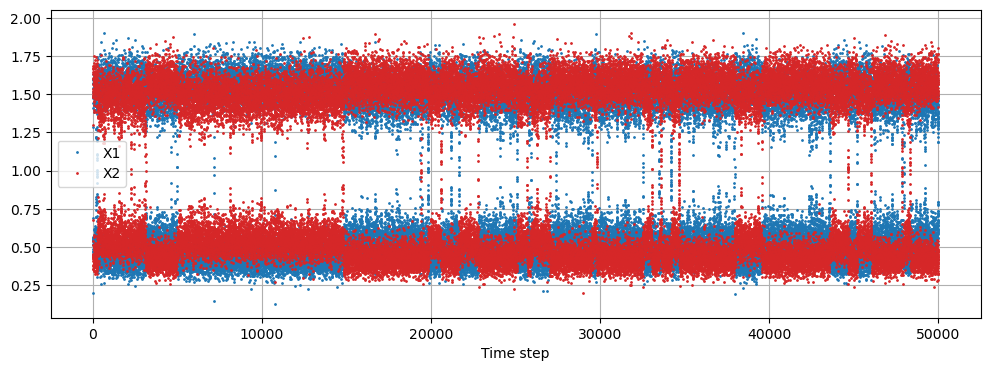

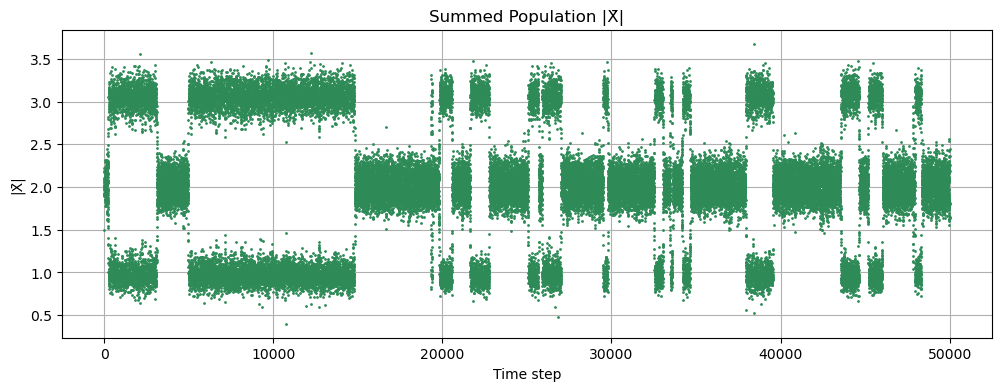

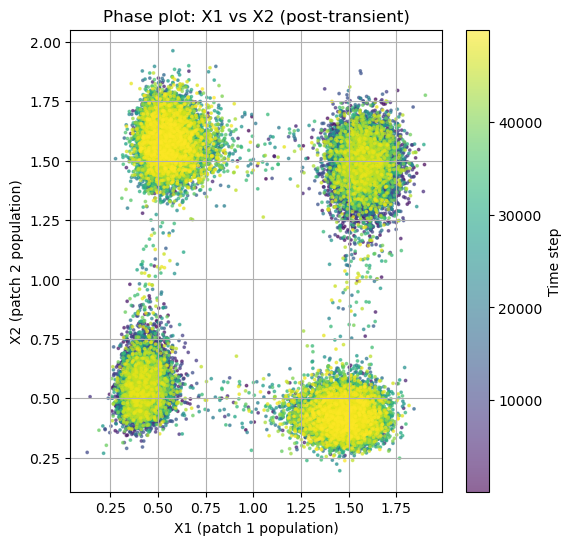

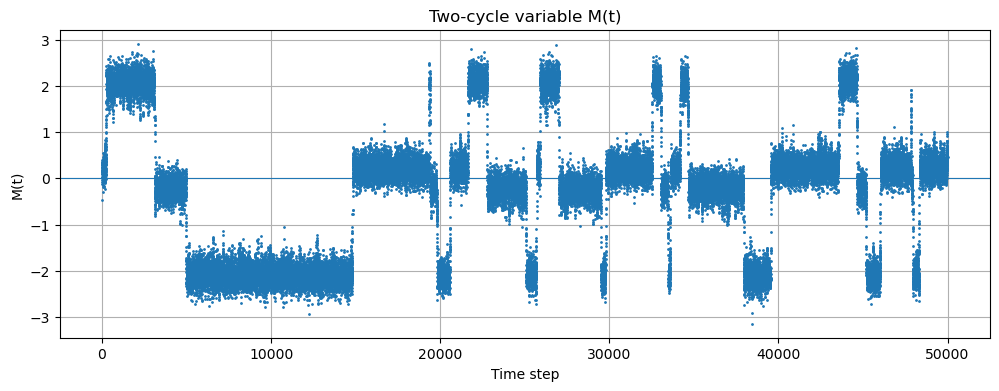

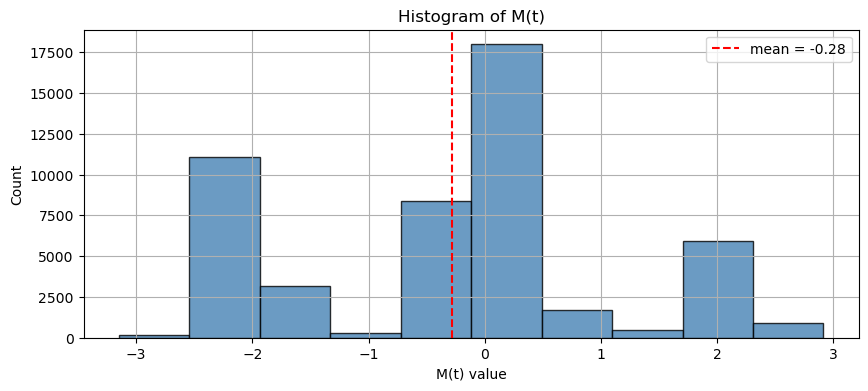

Overall Moran's R: -0.1207


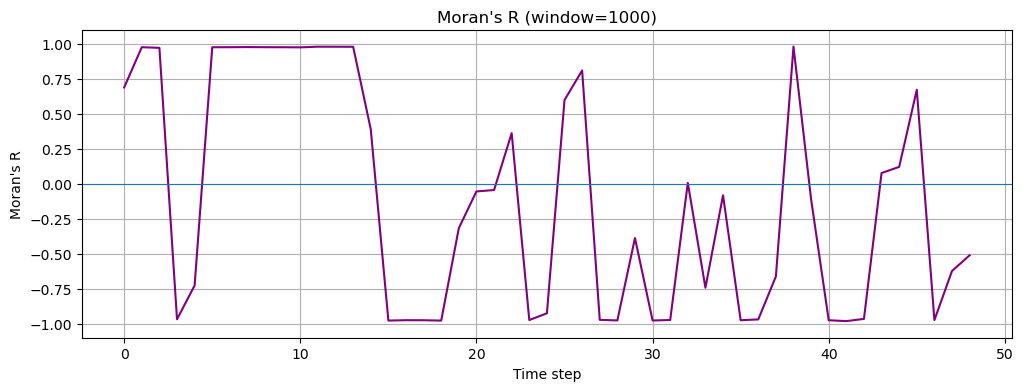

Estimated τ (fit lags 1–4828) ≈ 1420.9


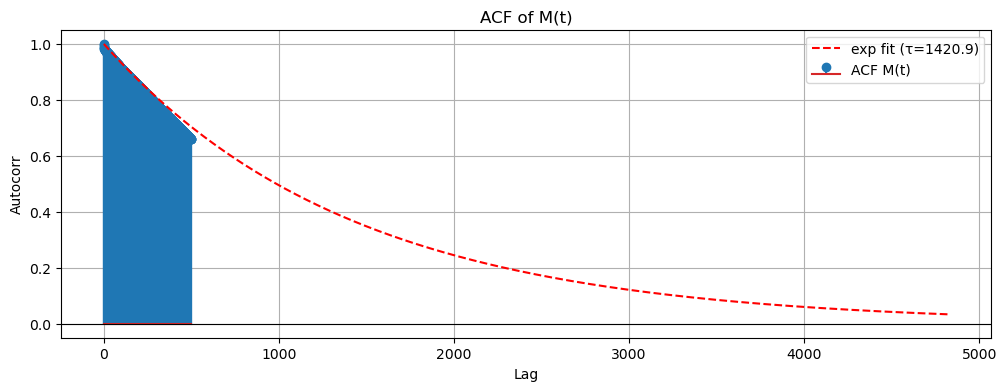

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import zscore
from statsmodels.tsa.stattools import acf as sm_acf
from scipy.signal import find_peaks

# ----------------------- parameters -----------------------
r            = 2.3
epsilon      = 0.05
local_sigma  = 0.05
global_scale = 0.071
num_steps    = 50000
transient    = 100
win_size     = 1000   # window length for moving‑Moran R
ACF_THRESH   = 0 # stop τ‑fit when ACF ≤ this value
# ----------------------------------------------------------

# --------------------- model helpers ----------------------
def R_ricker(x, r):
    """Density‑dependent Ricker map"""
    x = np.clip(x, 0, 10)
    return x * np.exp(r * (1 - x))

def eta(x, sigma):
    return x * np.exp(np.random.normal(0, sigma))

def global_noise(scale):
    σ = np.random.choice([0.1 * scale, 1 * scale], p=[0.98, 0.02])
    return np.random.normal(0, σ)

def coupled_ricker(x1, x2):
    g = global_noise(global_scale)
    x1 = eta((1 - epsilon) * R_ricker(x1, r) + epsilon * R_ricker(x2, r), local_sigma) + g
    x2 = eta((1 - epsilon) * R_ricker(x2, r) + epsilon * R_ricker(x1, r), local_sigma) + g
    return x1, x2
# ----------------------------------------------------------

# ----------------------- simulation -----------------------
X1, X2 = np.zeros(num_steps), np.zeros(num_steps)
X1[0], X2[0] = 0.2, 1.3
for t in range(num_steps - 1):
    X1[t + 1], X2[t + 1] = coupled_ricker(X1[t], X2[t])
# ----------------------------------------------------------

# ------------------------ quick plots ---------------------

def quick_plot(y, title, ylabel, n=None, **kw):
    n = slice(None) if n is None else slice(None, n)
    plt.plot(y[n], **kw)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Time step")
    plt.grid(True)

plt.figure(figsize=(12,4))
quick_plot(X1, "Oscillations", "Population", marker='o', markersize=1, linestyle='None', color="tab:blue", label="X1")
quick_plot(X2, "", "", marker='o', markersize=1, linestyle='None', color="tab:red", label="X2")
plt.legend(); plt.show()

X_bar = X1 + X2
plt.figure(figsize=(12,4))
quick_plot(X_bar, "Summed Population |X̄|", "|X̄|", marker='o', markersize=1, linestyle='None', color="seagreen"); plt.show()

#phase plot
plt.figure(figsize=(6, 6))
plt.scatter(
    X1[transient:], X2[transient:],     # post-transient points
    s=3, alpha=0.6,
    c=np.arange(transient, num_steps),  # colour = time
    cmap="viridis"
)
plt.xlabel("X1 (patch 1 population)")
plt.ylabel("X2 (patch 2 population)")
plt.title("Phase plot: X1 vs X2 (post-transient)")
plt.grid(True); plt.colorbar(label="Time step")
plt.show()

# ---------- M(t) ------------------

M = (-1) ** (np.arange(num_steps - 1) + 1) * np.diff(X_bar)
plt.figure(figsize=(12,4))
quick_plot(M, "Two‑cycle variable M(t)", "M(t)", marker='o', markersize=1, linestyle='None', color="tab:blue"); plt.axhline(0, lw=.8)
plt.show()


# ---------------------Histogram-------------------------------------
plt.figure(figsize=(10, 4))
plt.hist(M, bins=10, color="steelblue", edgecolor="k", alpha=0.8)
plt.axvline(M.mean(), color="red", ls="--", label=f"mean = {M.mean():.2f}")
plt.title("Histogram of M(t)")
plt.xlabel("M(t) value"); plt.ylabel("Count")
plt.legend(); plt.grid(True); plt.show()


# -------------------- moving‑Moran R(t) -------------------
X1_st, X2_st = X1[transient:], X2[transient:]
n_blocks = len(X1_st) // win_size
R_tv = np.array([
    np.corrcoef(zscore(X1_st[i*win_size : (i+1)*win_size]), 
                zscore(X2_st[i*win_size : (i+1)*win_size]))[0, 1]
    for i in range(n_blocks)
])
print(f"Overall Moran's R: {np.corrcoef(zscore(X1_st), zscore(X2_st))[0,1]:.4f}")

plt.figure(figsize=(12,4))
quick_plot(R_tv, f"Moran's R (window={win_size})", "Moran's R", color="purple")
plt.axhline(0, lw=.8); plt.ylim(-1.1, 1.1); plt.show()
# --------------- autocorrelation & τ-fit for M(t) ---------

def acf(x):
    x = x - np.nanmean(x)
    f = np.fft.fft(x, n=2*len(x))
    ac = np.fft.ifft(f * f.conjugate()).real[:len(x)]
    return ac / ac[0]

acf_vals = acf(M)                 # <-- now use M(t)
lags     = np.arange(len(acf_vals))

# find first lag (≥1) where ACF ≤ threshold; if never, use end
end_idx = np.argmax(acf_vals[1:] <= ACF_THRESH) + 1
end_idx = end_idx if end_idx > 1 else len(acf_vals)

x_fit = lags[1:end_idx]
y_fit = acf_vals[1:end_idx]
mask  = y_fit > 0                 # fit only positive points
x_fit, y_fit = x_fit[mask], y_fit[mask]

if len(x_fit) < 2:
    raise RuntimeError("Not enough positive ACF points to fit τ.")

tau_arr, _ = curve_fit(lambda k, t: np.exp(-k/t), x_fit, y_fit,
                       p0=[len(x_fit)/2])
τ = float(tau_arr[0])
print(f"Estimated τ (fit lags 1–{end_idx-1}) ≈ {τ:.1f}")

# ------------------------ ACF plot ------------------------
plt.figure(figsize=(12,4))
plt.stem(lags[:500], acf_vals[:500], label='ACF M(t)')
plt.plot(x_fit, np.exp(-x_fit/τ), 'r--',
         label=f'exp fit (τ={τ:.1f})')
plt.axhline(0, color='k', lw=.8)
plt.xlabel('Lag'); plt.ylabel('Autocorr'); plt.title('ACF of M(t)')
plt.legend(); plt.grid(True); plt.show()


--- Starting Analysis 1: 2D Bifurcation (r vs. epsilon) ---


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

--- Analysis 1 Complete ---

--- Starting Analysis 2: Local Noise vs. Tau ---


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:    4.1s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:    4.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    5.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


--- Analysis 2 Complete ---

--- Starting Analysis 3: Global Noise vs. Tau ---


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:    3.7s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:    4.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    5.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


--- Analysis 3 Complete ---

--- Starting Analysis 4: Shock Probability vs. Tau ---


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:    5.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    5.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.9s finished


--- Analysis 4 Complete ---

Consolidating all results into a single DataFrame...
✅ All results saved to 'simulation_results.csv'

Generating final dashboard...


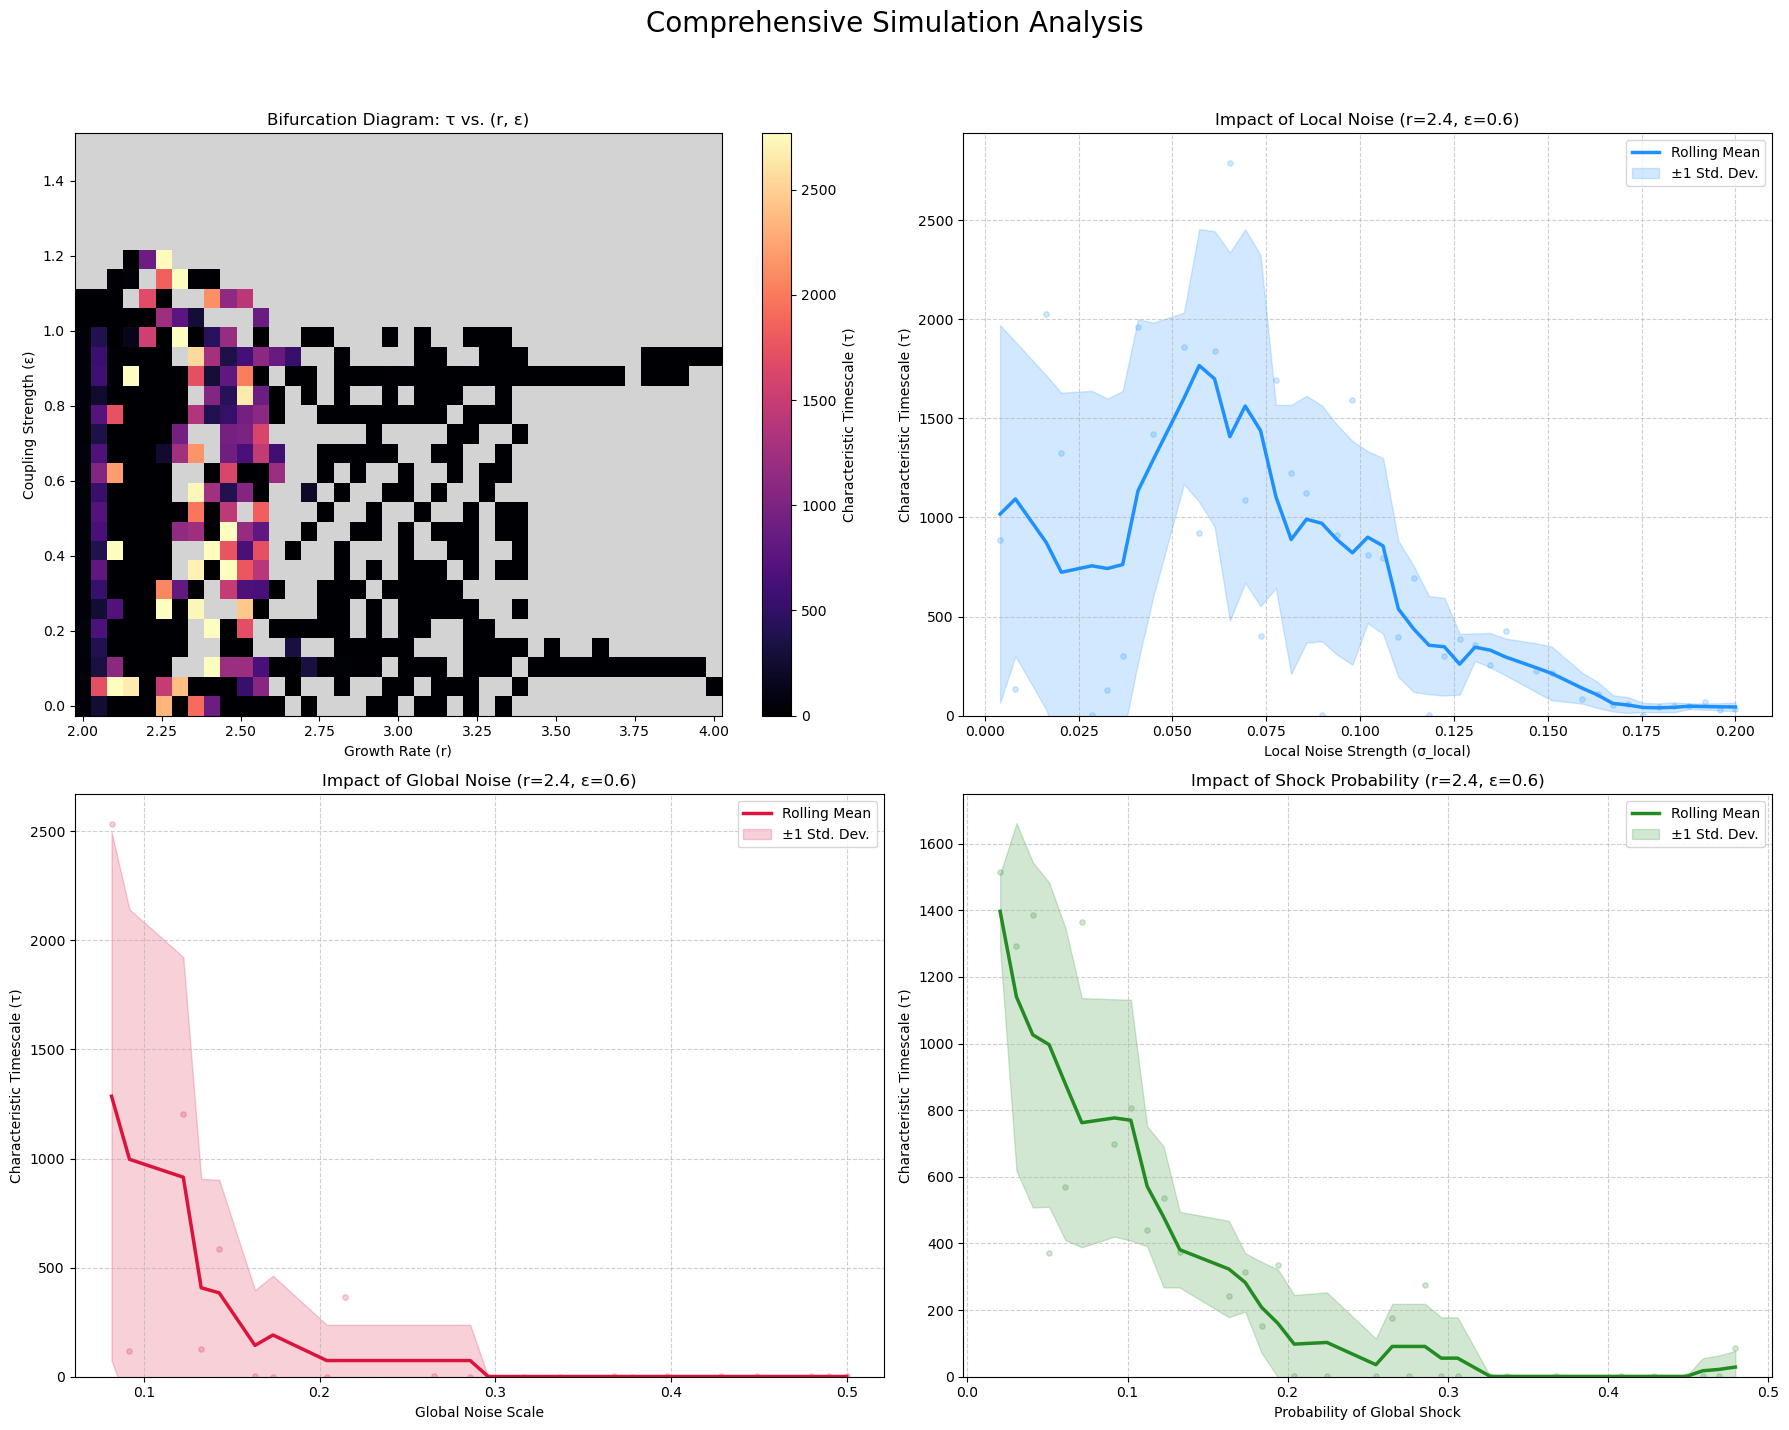

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
from joblib import Parallel, delayed
import pandas as pd # Import pandas for data handling

# --- The worker function (unchanged) ---
def get_tau_for_single_run(r, epsilon, local_sigma, global_scale, shock_prob):
    """
    A robust, pure Python function to compute tau for a given set of parameters.
    """
    # Parameters
    num_steps = 15000
    transient = 1000
    STABILITY_LIMIT = 1e9

    # Helper functions
    def R_ricker_internal(x, r_val):
        x_clipped = np.clip(x, -100, 100)
        return x_clipped * np.exp(r_val * (1 - x_clipped))
    def eta_internal(x, sigma):
        return x * np.exp(np.random.normal(0, sigma))
    def global_noise_internal(scale, prob):
        p_values = np.array([1.0 - prob, prob])
        σ = np.random.choice([0.1 * scale, 1 * scale], p=p_values)
        return np.random.normal(0, σ)
    def coupled_ricker_internal(x1, x2, r_val, eps_val, ls, gs, sp):
        g = global_noise_internal(gs, sp)
        x1_next = eta_internal((1 - eps_val) * R_ricker_internal(x1, r_val) + eps_val * R_ricker_internal(x2, r_val), ls) + g
        x2_next = eta_internal((1 - eps_val) * R_ricker_internal(x2, r_val) + eps_val * R_ricker_internal(x1, r_val), ls) + g
        return x1_next, x2_next

    # Simulation Loop
    X1, X2 = np.zeros(num_steps), np.zeros(num_steps)
    X1[0], X2[0] = 0.2, 1.3
    for t in range(num_steps - 1):
        X1[t + 1], X2[t + 1] = coupled_ricker_internal(X1[t], X2[t], r, epsilon, local_sigma, global_scale, shock_prob)
        if not (np.isfinite(X1[t + 1]) and np.isfinite(X2[t + 1])) or X1[t+1] > STABILITY_LIMIT:
            return np.nan

    # Analysis
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            X_bar = X1[transient:] + X2[transient:]
            if not np.all(np.isfinite(X_bar)) or len(X_bar) < 2: return np.nan
            M = (-1) ** (np.arange(len(X_bar) - 1) + 1) * np.diff(X_bar)
            if M.std() < 1e-6: return np.nan

            M_norm = M - np.nanmean(M)
            f = np.fft.fft(M_norm, n=2 * len(M_norm))
            acf_vals = np.fft.ifft(f * np.conj(f)).real[:len(M_norm)]
            if acf_vals[0] == 0: return np.nan
            acf_vals /= acf_vals[0]

            lags = np.arange(len(acf_vals))
            end_idx = np.argmax(acf_vals[1:] <= 0.0) + 1
            end_idx = end_idx if end_idx > 1 else len(acf_vals)
            x_fit, y_fit = lags[1:end_idx], acf_vals[1:end_idx]

            positive_points_mask = y_fit > 0
            if np.sum(positive_points_mask) < 2: return np.nan

            popt, _ = curve_fit(lambda k, t: np.exp(-k / t), x_fit[positive_points_mask], y_fit[positive_points_mask], p0=[10], maxfev=5000)
            return float(popt[0])
        except:
            return np.nan

# --- Analysis Setup ---
r_range_2d = np.linspace(2.0, 4.0, 40)
epsilon_range_2d = np.linspace(0.0, 1.5, 30)
local_sigma_range = np.linspace(0.0, 0.2, 50)
global_scale_range = np.linspace(0.0, 0.5, 50)
shock_prob_range = np.linspace(0.0, 0.5, 50)

FIXED_R = 2.4
FIXED_EPSILON = 0.6

# --- Running All Analyses ---
print("--- Starting Analysis 1: 2D Bifurcation (r vs. epsilon) ---")
param_pairs_2d = [(r, eps, 0.03, 0.1, 0.01) for eps in epsilon_range_2d for r in r_range_2d]
results_2d = Parallel(n_jobs=-1, verbose=10)(delayed(get_tau_for_single_run)(*p) for p in param_pairs_2d)
tau_grid_2d = np.array(results_2d).reshape(len(epsilon_range_2d), len(r_range_2d))
print("--- Analysis 1 Complete ---")

print("\n--- Starting Analysis 2: Local Noise vs. Tau ---")
param_pairs_local = [(FIXED_R, FIXED_EPSILON, ls, 0.1, 0.01) for ls in local_sigma_range]
results_local = Parallel(n_jobs=-1, verbose=10)(delayed(get_tau_for_single_run)(*p) for p in param_pairs_local)
print("--- Analysis 2 Complete ---")

print("\n--- Starting Analysis 3: Global Noise vs. Tau ---")
param_pairs_global = [(FIXED_R, FIXED_EPSILON, 0.03, gs, 0.01) for gs in global_scale_range]
results_global = Parallel(n_jobs=-1, verbose=10)(delayed(get_tau_for_single_run)(*p) for p in param_pairs_global)
print("--- Analysis 3 Complete ---")

print("\n--- Starting Analysis 4: Shock Probability vs. Tau ---")
param_pairs_shock = [(FIXED_R, FIXED_EPSILON, 0.03, 0.1, sp) for sp in shock_prob_range]
results_shock = Parallel(n_jobs=-1, verbose=10)(delayed(get_tau_for_single_run)(*p) for p in param_pairs_shock)
print("--- Analysis 4 Complete ---")


# --- ✅ NEW: Consolidate and Save All Data to a CSV File ---
print("\nConsolidating all results into a single DataFrame...")
all_results_data = []

# Add data from Analysis 1
for i, params in enumerate(param_pairs_2d):
    all_results_data.append({
        'analysis_type': '2D Bifurcation',
        'r': params[0], 'epsilon': params[1], 'local_sigma': params[2],
        'global_scale': params[3], 'shock_prob': params[4], 'tau': results_2d[i]
    })

# Add data from Analysis 2
for i, params in enumerate(param_pairs_local):
    all_results_data.append({
        'analysis_type': 'Local Noise',
        'r': params[0], 'epsilon': params[1], 'local_sigma': params[2],
        'global_scale': params[3], 'shock_prob': params[4], 'tau': results_local[i]
    })

# Add data from Analysis 3
for i, params in enumerate(param_pairs_global):
    all_results_data.append({
        'analysis_type': 'Global Noise',
        'r': params[0], 'epsilon': params[1], 'local_sigma': params[2],
        'global_scale': params[3], 'shock_prob': params[4], 'tau': results_global[i]
    })

# Add data from Analysis 4
for i, params in enumerate(param_pairs_shock):
    all_results_data.append({
        'analysis_type': 'Shock Probability',
        'r': params[0], 'epsilon': params[1], 'local_sigma': params[2],
        'global_scale': params[3], 'shock_prob': params[4], 'tau': results_shock[i]
    })

# Create a pandas DataFrame and save to CSV
results_df = pd.DataFrame(all_results_data)
results_df.to_csv('simulation_results.csv', index=False)
print("✅ All results saved to 'simulation_results.csv'")


# --- Plotting All Results in a Dashboard ---
print("\nGenerating final dashboard...")
fig, axs = plt.subplots(2, 2, figsize=(18, 15))
fig.suptitle('Comprehensive Simulation Analysis', fontsize=20)

# Plot 1: 2D Bifurcation
ax = axs[0, 0]
ax.set_facecolor('lightgray')
im = ax.pcolormesh(r_range_2d, epsilon_range_2d, tau_grid_2d, shading='auto', cmap='magma', vmin=0, vmax=np.nanpercentile(tau_grid_2d, 98))
fig.colorbar(im, ax=ax, label='Characteristic Timescale (τ)')
ax.set_xlabel('Growth Rate (r)')
ax.set_ylabel('Coupling Strength (ε)')
ax.set_title('Bifurcation Diagram: τ vs. (r, ε)')

# --- Helper function for clean 1D plots ---
def clean_1d_plot(ax, x_data, y_data, color, title, xlabel):
    s = pd.Series(y_data, index=x_data).dropna()
    if s.empty: # Handle cases with no valid data
        ax.text(0.5, 0.5, 'No valid data to plot', ha='center', va='center', transform=ax.transAxes)
        return
        
    rolling_mean = s.rolling(window=5, center=True, min_periods=2).mean()
    rolling_std = s.rolling(window=5, center=True, min_periods=2).std()
    
    ax.scatter(s.index, s.values, alpha=0.2, color=color, s=15)
    ax.plot(rolling_mean.index, rolling_mean.values, color=color, linewidth=2.5, label='Rolling Mean')
    ax.fill_between(rolling_mean.index, (rolling_mean - rolling_std), (rolling_mean + rolling_std), color=color, alpha=0.2, label='±1 Std. Dev.')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Characteristic Timescale (τ)')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    ax.set_ylim(bottom=0)

# Plot 2: Local Noise
clean_1d_plot(axs[0, 1], local_sigma_range, results_local, color='dodgerblue',
              title=f'Impact of Local Noise (r={FIXED_R}, ε={FIXED_EPSILON})',
              xlabel='Local Noise Strength (σ_local)')

# Plot 3: Global Noise
clean_1d_plot(axs[1, 0], global_scale_range, results_global, color='crimson',
              title=f'Impact of Global Noise (r={FIXED_R}, ε={FIXED_EPSILON})',
              xlabel='Global Noise Scale')

# Plot 4: Shock Probability
clean_1d_plot(axs[1, 1], shock_prob_range, results_shock, color='forestgreen',
              title=f'Impact of Shock Probability (r={FIXED_R}, ε={FIXED_EPSILON})',
              xlabel='Probability of Global Shock')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

--- Starting Analysis 1: 3D Sweep of r vs. Noise ---
Executing 4800 simulations for Analysis 1...


100%|██████████████████████████████████████████████████████████████████████████████| 4800/4800 [08:42<00:00,  9.19it/s]


--- ✅ Analysis 1 Complete & Saved ---

--- Starting Analysis 2: 3D Sweep of epsilon vs. Noise ---
Executing 4800 simulations for Analysis 2...


100%|██████████████████████████████████████████████████████████████████████████████| 4800/4800 [09:03<00:00,  8.83it/s]


--- ✅ Analysis 2 Complete & Saved ---

Simulations complete. Generating final dashboard...


C:\Users\rajya\AppData\Local\Temp\ipykernel_26528\2244563427.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95], pad=2.0, h_pad=3.0)


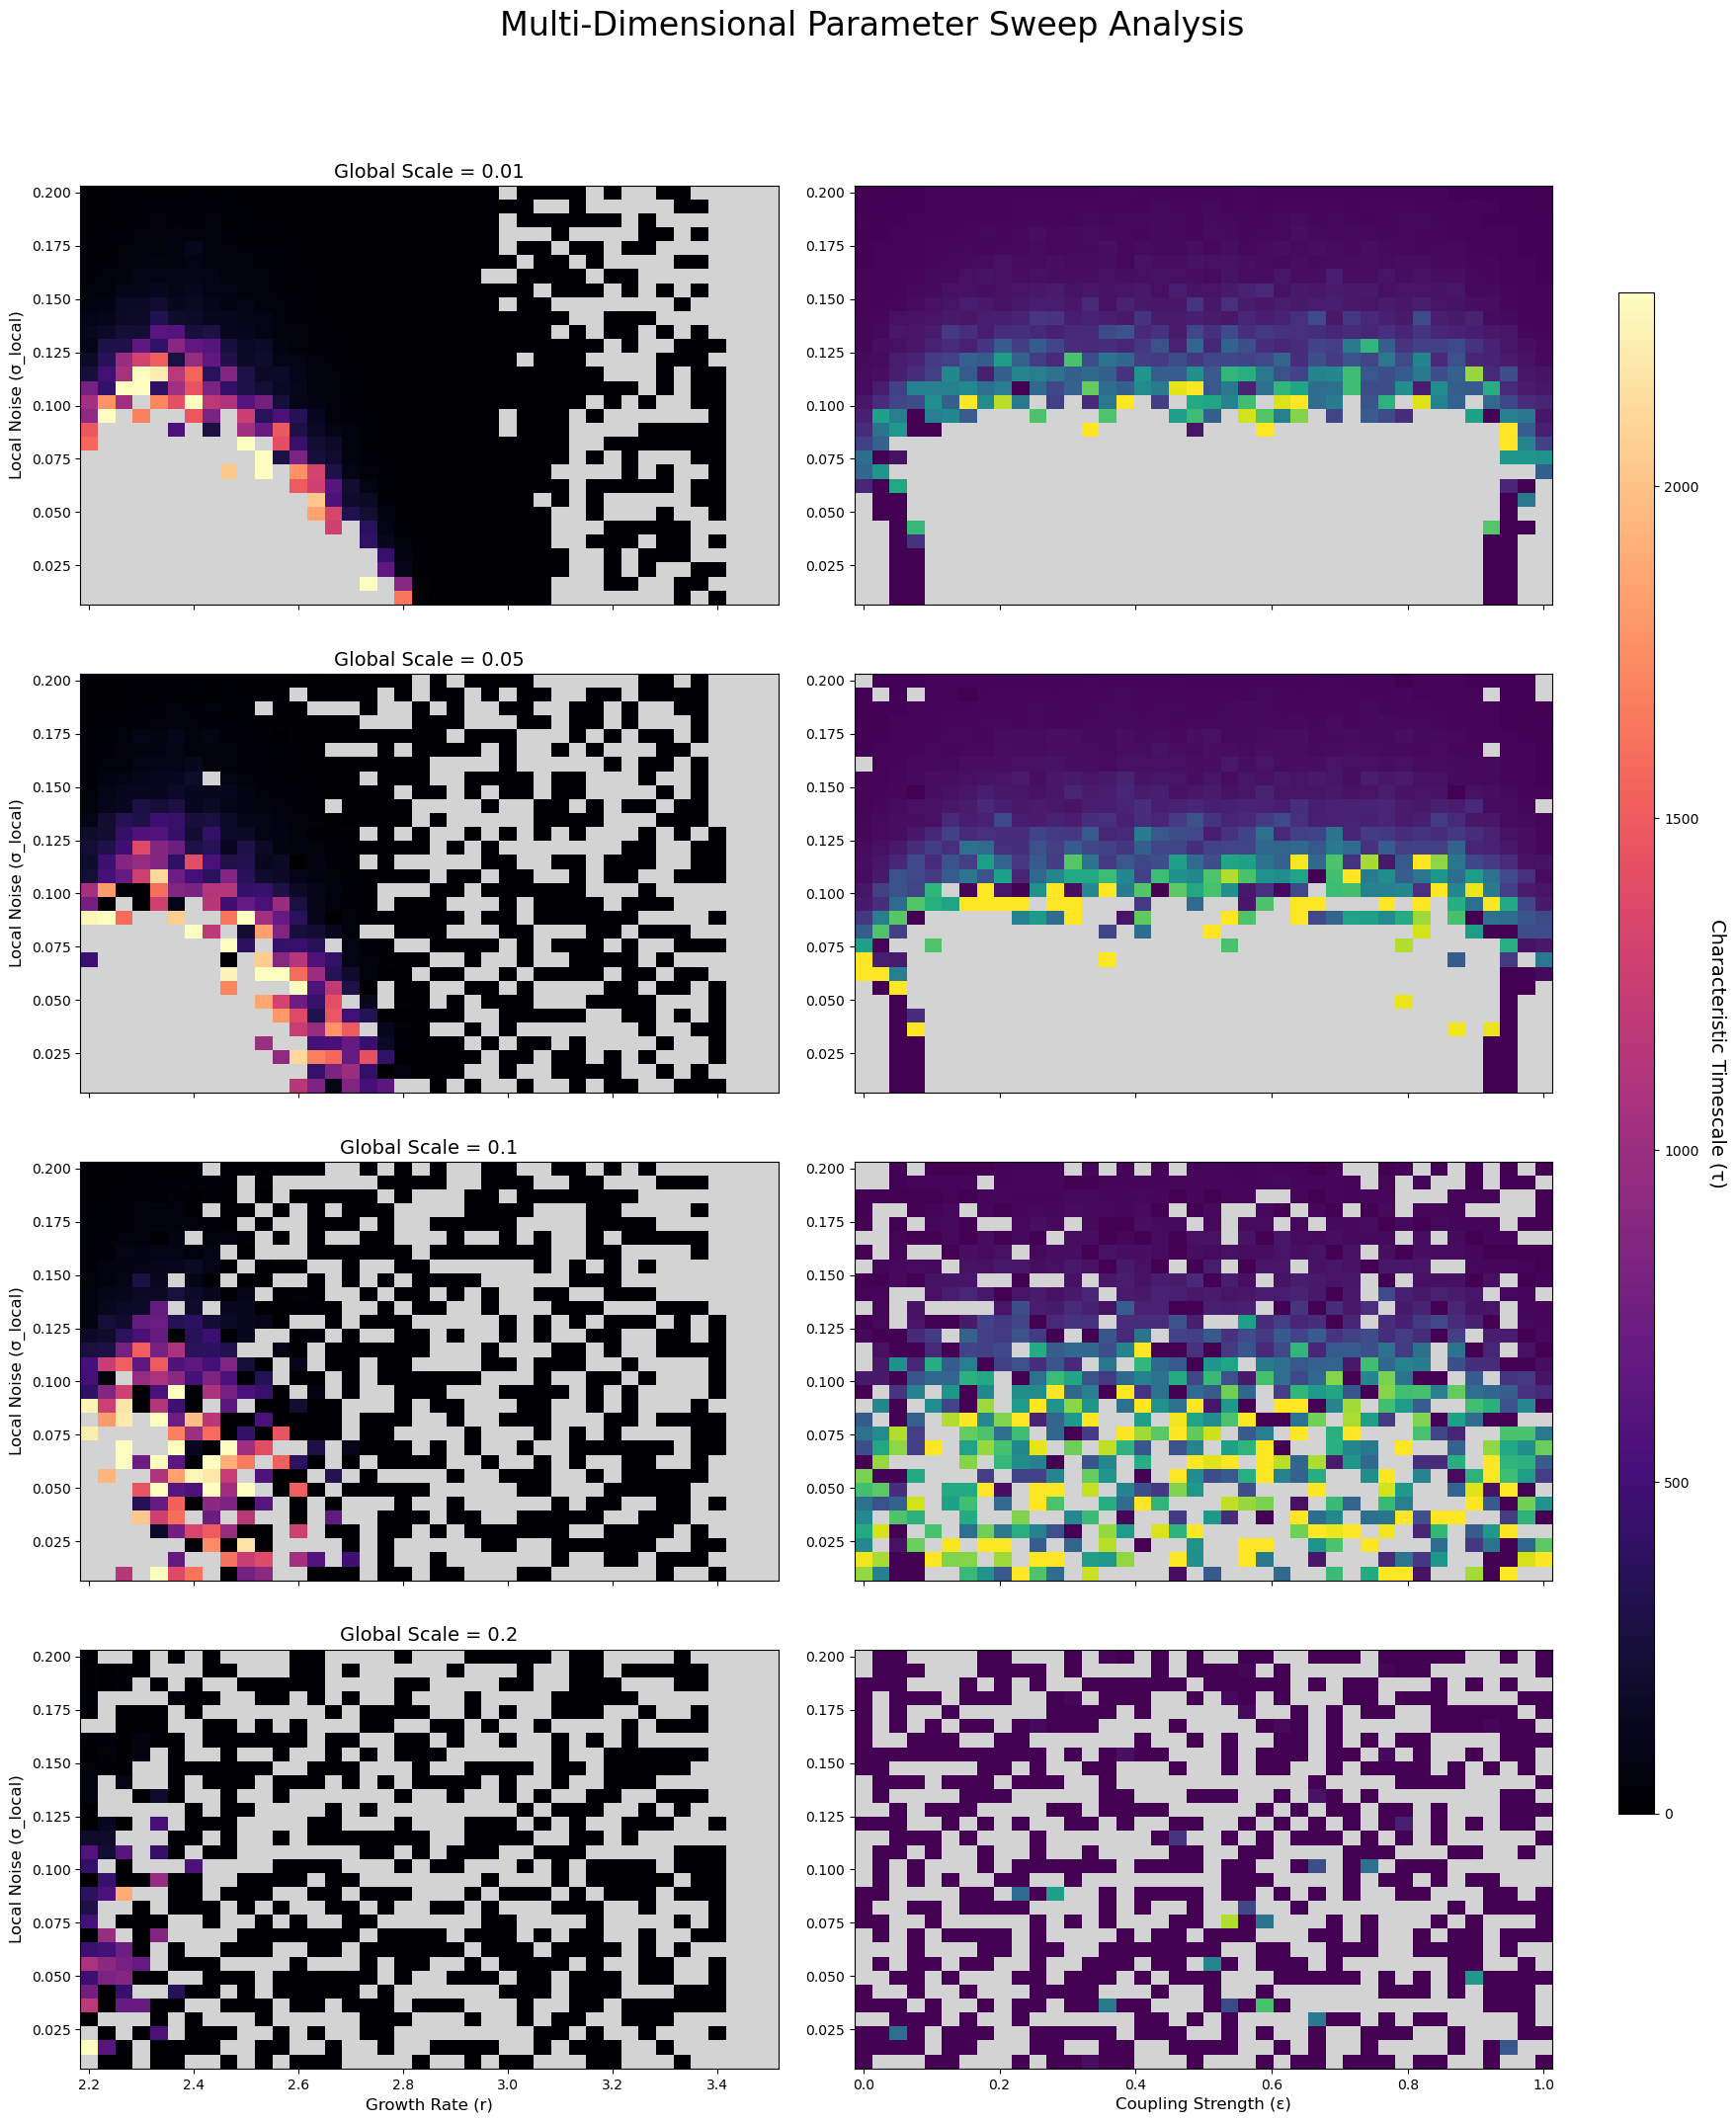

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
from joblib import Parallel, delayed
import pandas as pd
import time

# --- The Final, Robust Worker Function ---
def get_tau_for_single_run(r, epsilon, local_sigma, global_scale, shock_prob):
    """
    A robust function to compute tau. It's designed to find tau when phase-switching
    (sign-flipping in M) occurs and return NaN otherwise. A small amount of noise
    is often required to induce this switching.
    """
    # Parameters
    num_steps, transient = 15000, 2000 # Longer transient for stability
    STABILITY_LIMIT = 1e9

    # Helper functions
    def R_ricker_internal(x, r_val):
        x_clipped = np.clip(x, -100, 100)
        return x_clipped * np.exp(r_val * (1 - x_clipped))
    def eta_internal(x, sigma):
        return x * np.exp(np.random.normal(0, sigma))
    def global_noise_internal(scale, prob):
        p_values = np.array([1.0 - prob, prob])
        σ = np.random.choice([0.1 * scale, 1 * scale], p=p_values)
        return np.random.normal(0, σ)
    def coupled_ricker_internal(x1, x2, r_val, eps_val, ls, gs, sp):
        g = global_noise_internal(gs, sp)
        x1_next = eta_internal((1 - eps_val) * R_ricker_internal(x1, r_val) + eps_val * R_ricker_internal(x2, r_val), ls) + g
        x2_next = eta_internal((1 - eps_val) * R_ricker_internal(x2, r_val) + eps_val * R_ricker_internal(x1, r_val), ls) + g
        return x1_next, x2_next

    # Simulation Loop
    X1, X2 = np.zeros(num_steps), np.zeros(num_steps)
    X1[0], X2[0] = 0.2, 1.3
    for t in range(num_steps - 1):
        X1[t + 1], X2[t + 1] = coupled_ricker_internal(X1[t], X2[t], r, epsilon, local_sigma, global_scale, shock_prob)
        if not (np.isfinite(X1[t + 1]) and np.isfinite(X2[t + 1])) or X1[t+1] > STABILITY_LIMIT:
            return np.nan

    # Analysis
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            X_bar = X1[transient:] + X2[transient:]
            if not np.all(np.isfinite(X_bar)) or len(X_bar) < 2: return np.nan
            M = (-1) ** (np.arange(len(X_bar) - 1) + 1) * np.diff(X_bar)
            if M.std() < 1e-6: return np.nan
            # This is the critical check for phase-switching.
            if np.all(M > 0) or np.all(M < 0): return np.nan 

            M_norm = M - np.nanmean(M)
            f = np.fft.fft(M_norm, n=2 * len(M_norm))
            acf_vals = np.fft.ifft(f * np.conj(f)).real[:len(M_norm)]
            if acf_vals[0] == 0: return np.nan
            acf_vals /= acf_vals[0]
            
            lags = np.arange(len(acf_vals))
            end_idx = np.argmax(acf_vals[1:] <= 0.0) + 1
            end_idx = end_idx if end_idx > 1 else len(acf_vals)
            x_fit, y_fit = lags[1:end_idx], acf_vals[1:end_idx]
            
            positive_points_mask = y_fit > 0
            if np.sum(positive_points_mask) < 2: return np.nan
            
            popt, _ = curve_fit(lambda k, t: np.exp(-k / t), x_fit[positive_points_mask], y_fit[positive_points_mask], p0=[10], maxfev=5000)
            return float(popt[0])
        except:
            return np.nan

# --- Analysis 1: 3D Sweep (r, local_sigma, global_scale) ---
print("--- Starting Analysis 1: 3D Sweep of r vs. Noise ---")
r_range_3d = np.linspace(2.2, 3.5, 40)
local_sigma_range_3d = np.linspace(0.01, 0.2, 30)
global_scale_slices = np.array([0.01, 0.05, 0.1, 0.2]) # 4 slices
param_pairs_3d_r = [(r, 0.5, ls, gs, 0.01) for gs in global_scale_slices for ls in local_sigma_range_3d for r in r_range_3d]
print(f"Executing {len(param_pairs_3d_r)} simulations for Analysis 1...")
results_3d_r = Parallel(n_jobs=-1)(delayed(get_tau_for_single_run)(*p) for p in tqdm(param_pairs_3d_r))
df_3d_r = pd.DataFrame(param_pairs_3d_r, columns=['r', 'epsilon', 'local_sigma', 'global_scale', 'shock_prob'])
df_3d_r['tau'] = results_3d_r
df_3d_r.to_csv('results_3d_r_vs_noise.csv', index=False)
print("--- ✅ Analysis 1 Complete & Saved ---")

# --- Analysis 2: 3D Sweep (epsilon, local_sigma, global_scale) ---
print("\n--- Starting Analysis 2: 3D Sweep of epsilon vs. Noise ---")
epsilon_range_3d = np.linspace(0.0, 1.0, 40)
# Re-using local_sigma_range_3d and global_scale_slices
param_pairs_3d_eps = [(2.4, eps, ls, gs, 0.01) for gs in global_scale_slices for ls in local_sigma_range_3d for eps in epsilon_range_3d]
print(f"Executing {len(param_pairs_3d_eps)} simulations for Analysis 2...")
results_3d_eps = Parallel(n_jobs=-1)(delayed(get_tau_for_single_run)(*p) for p in tqdm(param_pairs_3d_eps))
df_3d_eps = pd.DataFrame(param_pairs_3d_eps, columns=['r', 'epsilon', 'local_sigma', 'global_scale', 'shock_prob'])
df_3d_eps['tau'] = results_3d_eps
df_3d_eps.to_csv('results_3d_epsilon_vs_noise.csv', index=False)
print("--- ✅ Analysis 2 Complete & Saved ---")

# --- Plotting All Results in a Dashboard ---
print("\nSimulations complete. Generating final dashboard...")
fig, axs = plt.subplots(len(global_scale_slices), 2, figsize=(18, 22), sharex='col', sharey='col')
fig.suptitle('Multi-Dimensional Parameter Sweep Analysis', fontsize=24)

# Determine a consistent color scale for both sets of plots
vmax = np.nanpercentile(np.concatenate([df_3d_r['tau'].dropna(), df_3d_eps['tau'].dropna()]), 98)

for i, gs in enumerate(global_scale_slices):
    # Plotting for Analysis 1: Tau vs (r, local_sigma)
    ax1 = axs[i, 0]
    subset1 = df_3d_r[df_3d_r['global_scale'] == gs]
    grid1 = subset1['tau'].values.reshape(len(local_sigma_range_3d), len(r_range_3d))
    
    ax1.set_facecolor('lightgray')
    im1 = ax1.pcolormesh(r_range_3d, local_sigma_range_3d, grid1, shading='auto', cmap='magma', vmin=0, vmax=vmax)
    ax1.set_title(f'Global Scale = {gs}', fontsize=14)
    if i == len(global_scale_slices) - 1:
        ax1.set_xlabel('Growth Rate (r)', fontsize=12)
    ax1.set_ylabel('Local Noise (σ_local)', fontsize=12)

    # Plotting for Analysis 2: Tau vs (epsilon, local_sigma)
    ax2 = axs[i, 1]
    subset2 = df_3d_eps[df_3d_eps['global_scale'] == gs]
    grid2 = subset2['tau'].values.reshape(len(local_sigma_range_3d), len(epsilon_range_3d))

    ax2.set_facecolor('lightgray')
    im2 = ax2.pcolormesh(epsilon_range_3d, local_sigma_range_3d, grid2, shading='auto', cmap='viridis', vmin=0, vmax=vmax)
    if i == len(global_scale_slices) - 1:
        ax2.set_xlabel('Coupling Strength (ε)', fontsize=12)
    # No y-label needed as it's shared with the left plot

# Create a single, shared colorbar for all heatmaps
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Characteristic Timescale (τ)', fontsize=14, rotation=270, labelpad=20)

plt.tight_layout(rect=[0, 0, 0.9, 0.95], pad=2.0, h_pad=3.0)
plt.show()

✅ Successfully loaded both CSV files.


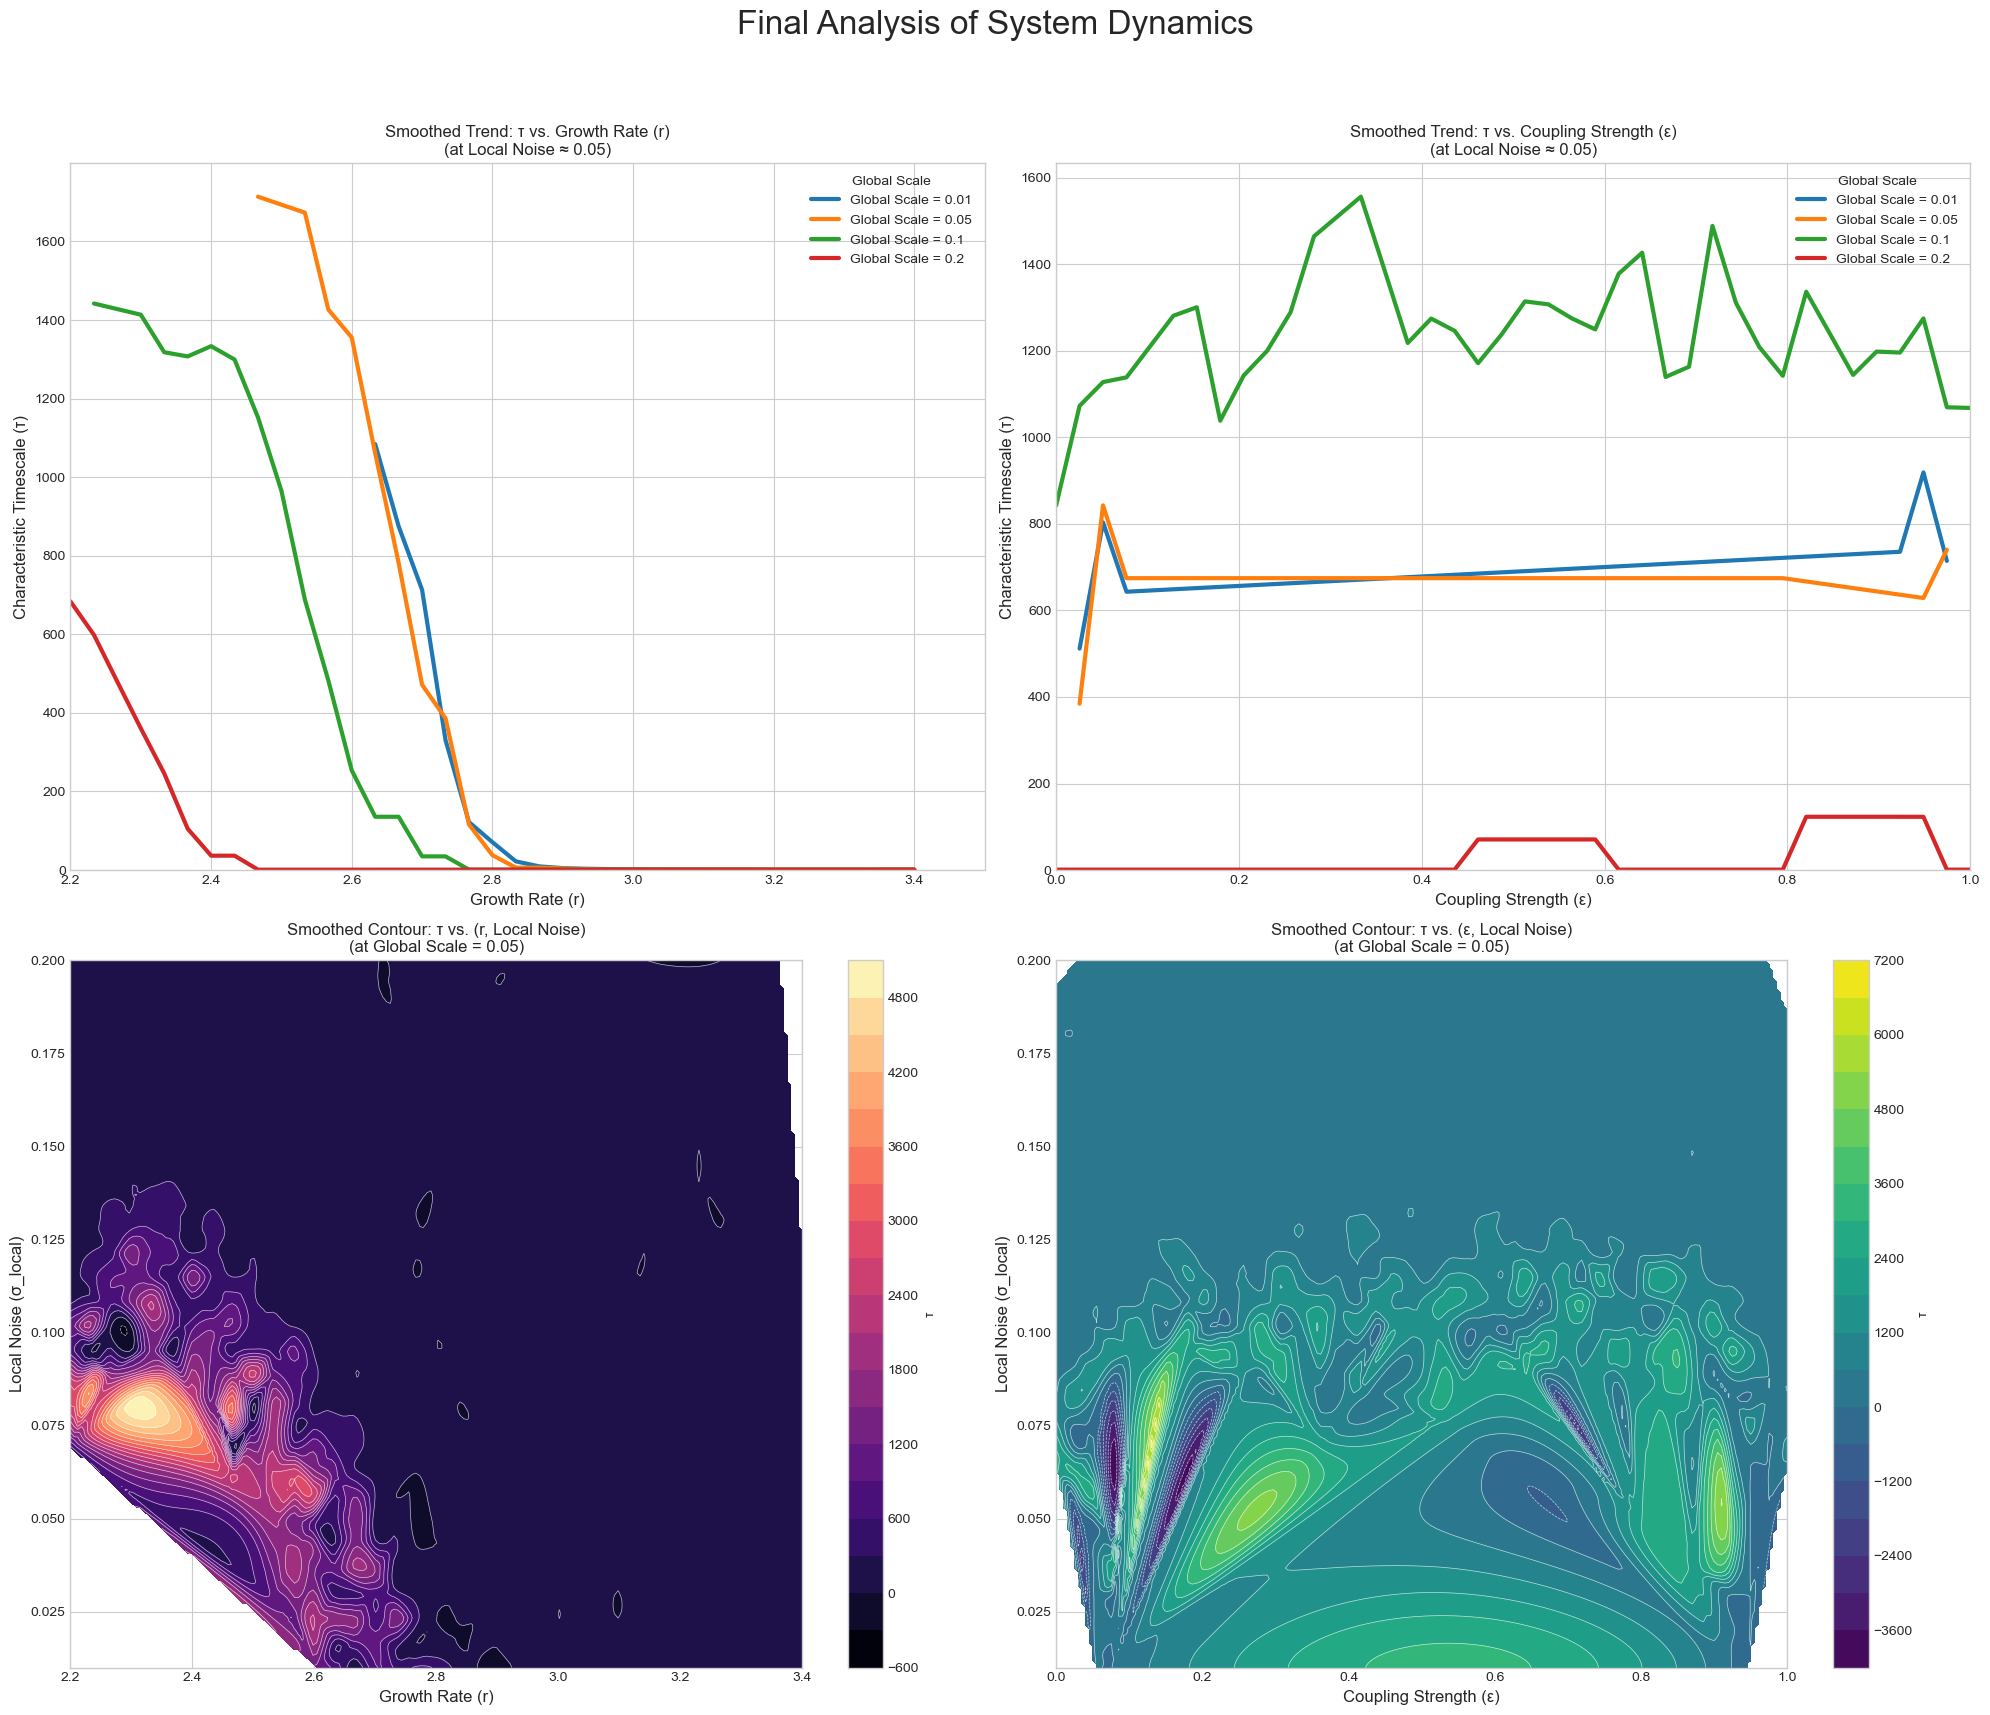

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# --- Use a clean, professional plotting style ---
plt.style.use('seaborn-v0_8-whitegrid')

# --- Load your previously saved data ---
try:
    df_r = pd.read_csv('results_3d_r_vs_noise.csv').dropna()
    df_eps = pd.read_csv('results_3d_epsilon_vs_noise.csv').dropna()
    print("✅ Successfully loaded both CSV files.")
except FileNotFoundError as e:
    print(f"❌ Error: {e}. Please make sure both CSV files are available.")
    # Create dummy dataframes so the rest of the code doesn't crash.
    df_r = pd.DataFrame(columns=['r', 'local_sigma', 'global_scale', 'tau'])
    df_eps = pd.DataFrame(columns=['epsilon', 'local_sigma', 'global_scale', 'tau'])

# --- Create the Dashboard ---
fig, axs = plt.subplots(2, 2, figsize=(20, 18))
fig.suptitle('Final Analysis of System Dynamics', fontsize=24)

# --- Plot 1: Smoothed 1D Slice - The effect of 'r' ---
ax = axs[0, 0]
fixed_local_sigma = 0.05
data_slice1 = df_r[np.isclose(df_r['local_sigma'], fixed_local_sigma, atol=0.01)]

for gs in sorted(data_slice1['global_scale'].unique()):
    subset = data_slice1[data_slice1['global_scale'] == gs]
    # ✅ FIX: First, calculate the mean. Then, smooth the mean with a rolling average.
    mean_tau = subset.groupby('r')['tau'].mean()
    smoothed_mean_tau = mean_tau.rolling(window=5, center=True, min_periods=2).mean()
    ax.plot(smoothed_mean_tau.index, smoothed_mean_tau.values, lw=3, label=f'Global Scale = {gs}')

ax.set_title(f'Smoothed Trend: τ vs. Growth Rate (r)\n(at Local Noise ≈ {fixed_local_sigma})')
ax.set_xlabel('Growth Rate (r)', fontsize=12)
ax.set_ylabel('Characteristic Timescale (τ)', fontsize=12)
ax.legend(title='Global Scale')
ax.set_ylim(bottom=0)
ax.set_xlim(2.2, 3.5)


# --- Plot 2: Smoothed 1D Slice - The effect of 'epsilon' ---
ax = axs[0, 1]
fixed_local_sigma_eps = 0.05
data_slice2 = df_eps[np.isclose(df_eps['local_sigma'], fixed_local_sigma_eps, atol=0.01)]

for gs in sorted(data_slice2['global_scale'].unique()):
    subset = data_slice2[data_slice2['global_scale'] == gs]
    # ✅ FIX: First, calculate the mean. Then, smooth the mean with a rolling average.
    mean_tau = subset.groupby('epsilon')['tau'].mean()
    smoothed_mean_tau = mean_tau.rolling(window=5, center=True, min_periods=2).mean()
    ax.plot(smoothed_mean_tau.index, smoothed_mean_tau.values, lw=3, label=f'Global Scale = {gs}')

ax.set_title(f'Smoothed Trend: τ vs. Coupling Strength (ε)\n(at Local Noise ≈ {fixed_local_sigma_eps})')
ax.set_xlabel('Coupling Strength (ε)', fontsize=12)
ax.set_ylabel('Characteristic Timescale (τ)', fontsize=12)
ax.legend(title='Global Scale')
ax.set_ylim(bottom=0)
ax.set_xlim(0, 1.0)


# --- Plot 3: Interpolated Contour Plot for r vs. Noise ---
ax = axs[1, 0]
fixed_global_scale_r = 0.05
subset_r = df_r[np.isclose(df_r['global_scale'], fixed_global_scale_r)]

if not subset_r.empty:
    xi = np.linspace(subset_r['r'].min(), subset_r['r'].max(), 200)
    yi = np.linspace(subset_r['local_sigma'].min(), subset_r['local_sigma'].max(), 200)
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((subset_r['r'], subset_r['local_sigma']), subset_r['tau'], (X, Y), method='cubic')
    
    contour = ax.contourf(X, Y, Z, levels=20, cmap='magma')
    ax.contour(X, Y, Z, levels=20, colors='white', linewidths=0.5, alpha=0.7)
    fig.colorbar(contour, ax=ax, label='τ')
    ax.set_title(f'Smoothed Contour: τ vs. (r, Local Noise)\n(at Global Scale = {fixed_global_scale_r})')
    ax.set_xlabel('Growth Rate (r)', fontsize=12)
    ax.set_ylabel('Local Noise (σ_local)', fontsize=12)
else:
    ax.text(0.5, 0.5, 'No data for this slice', ha='center', va='center')


# --- Plot 4: Interpolated Contour Plot for epsilon vs. Noise ---
ax = axs[1, 1]
fixed_global_scale_eps = 0.05
subset_eps = df_eps[np.isclose(df_eps['global_scale'], fixed_global_scale_eps)]

if not subset_eps.empty:
    xi_e = np.linspace(subset_eps['epsilon'].min(), subset_eps['epsilon'].max(), 200)
    yi_e = np.linspace(subset_eps['local_sigma'].min(), subset_eps['local_sigma'].max(), 200)
    X_e, Y_e = np.meshgrid(xi_e, yi_e)
    
    Z_e = griddata((subset_eps['epsilon'], subset_eps['local_sigma']), subset_eps['tau'], (X_e, Y_e), method='cubic')
    
    contour_e = ax.contourf(X_e, Y_e, Z_e, levels=20, cmap='viridis')
    ax.contour(X_e, Y_e, Z_e, levels=20, colors='white', linewidths=0.5, alpha=0.7)
    fig.colorbar(contour_e, ax=ax, label='τ')
    ax.set_title(f'Smoothed Contour: τ vs. (ε, Local Noise)\n(at Global Scale = {fixed_global_scale_eps})')
    ax.set_xlabel('Coupling Strength (ε)', fontsize=12)
    ax.set_ylabel('Local Noise (σ_local)', fontsize=12)
else:
    ax.text(0.5, 0.5, 'No data for this slice', ha='center', va='center')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Starting FINAL Analysis 1: High-Res 3D Sweep of r vs. Noise ---
Executing 32000 simulations for Analysis 1...


100%|██████████████████████████████████████████████████████████████████████████| 32000/32000 [2:59:00<00:00,  2.98it/s]


--- ✅ Analysis 1 Complete & Saved ---

--- Starting FINAL Analysis 2: High-Res 3D Sweep of epsilon vs. Noise ---
Executing 32000 simulations for Analysis 2. This will take a long time...


100%|██████████████████████████████████████████████████████████████████████████| 32000/32000 [5:17:51<00:00,  1.68it/s]


--- ✅ Analysis 2 Complete & Saved ---

Simulations complete. Generating final high-resolution dashboard...


C:\Users\rajya\AppData\Local\Temp\ipykernel_26528\2974225744.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.96])


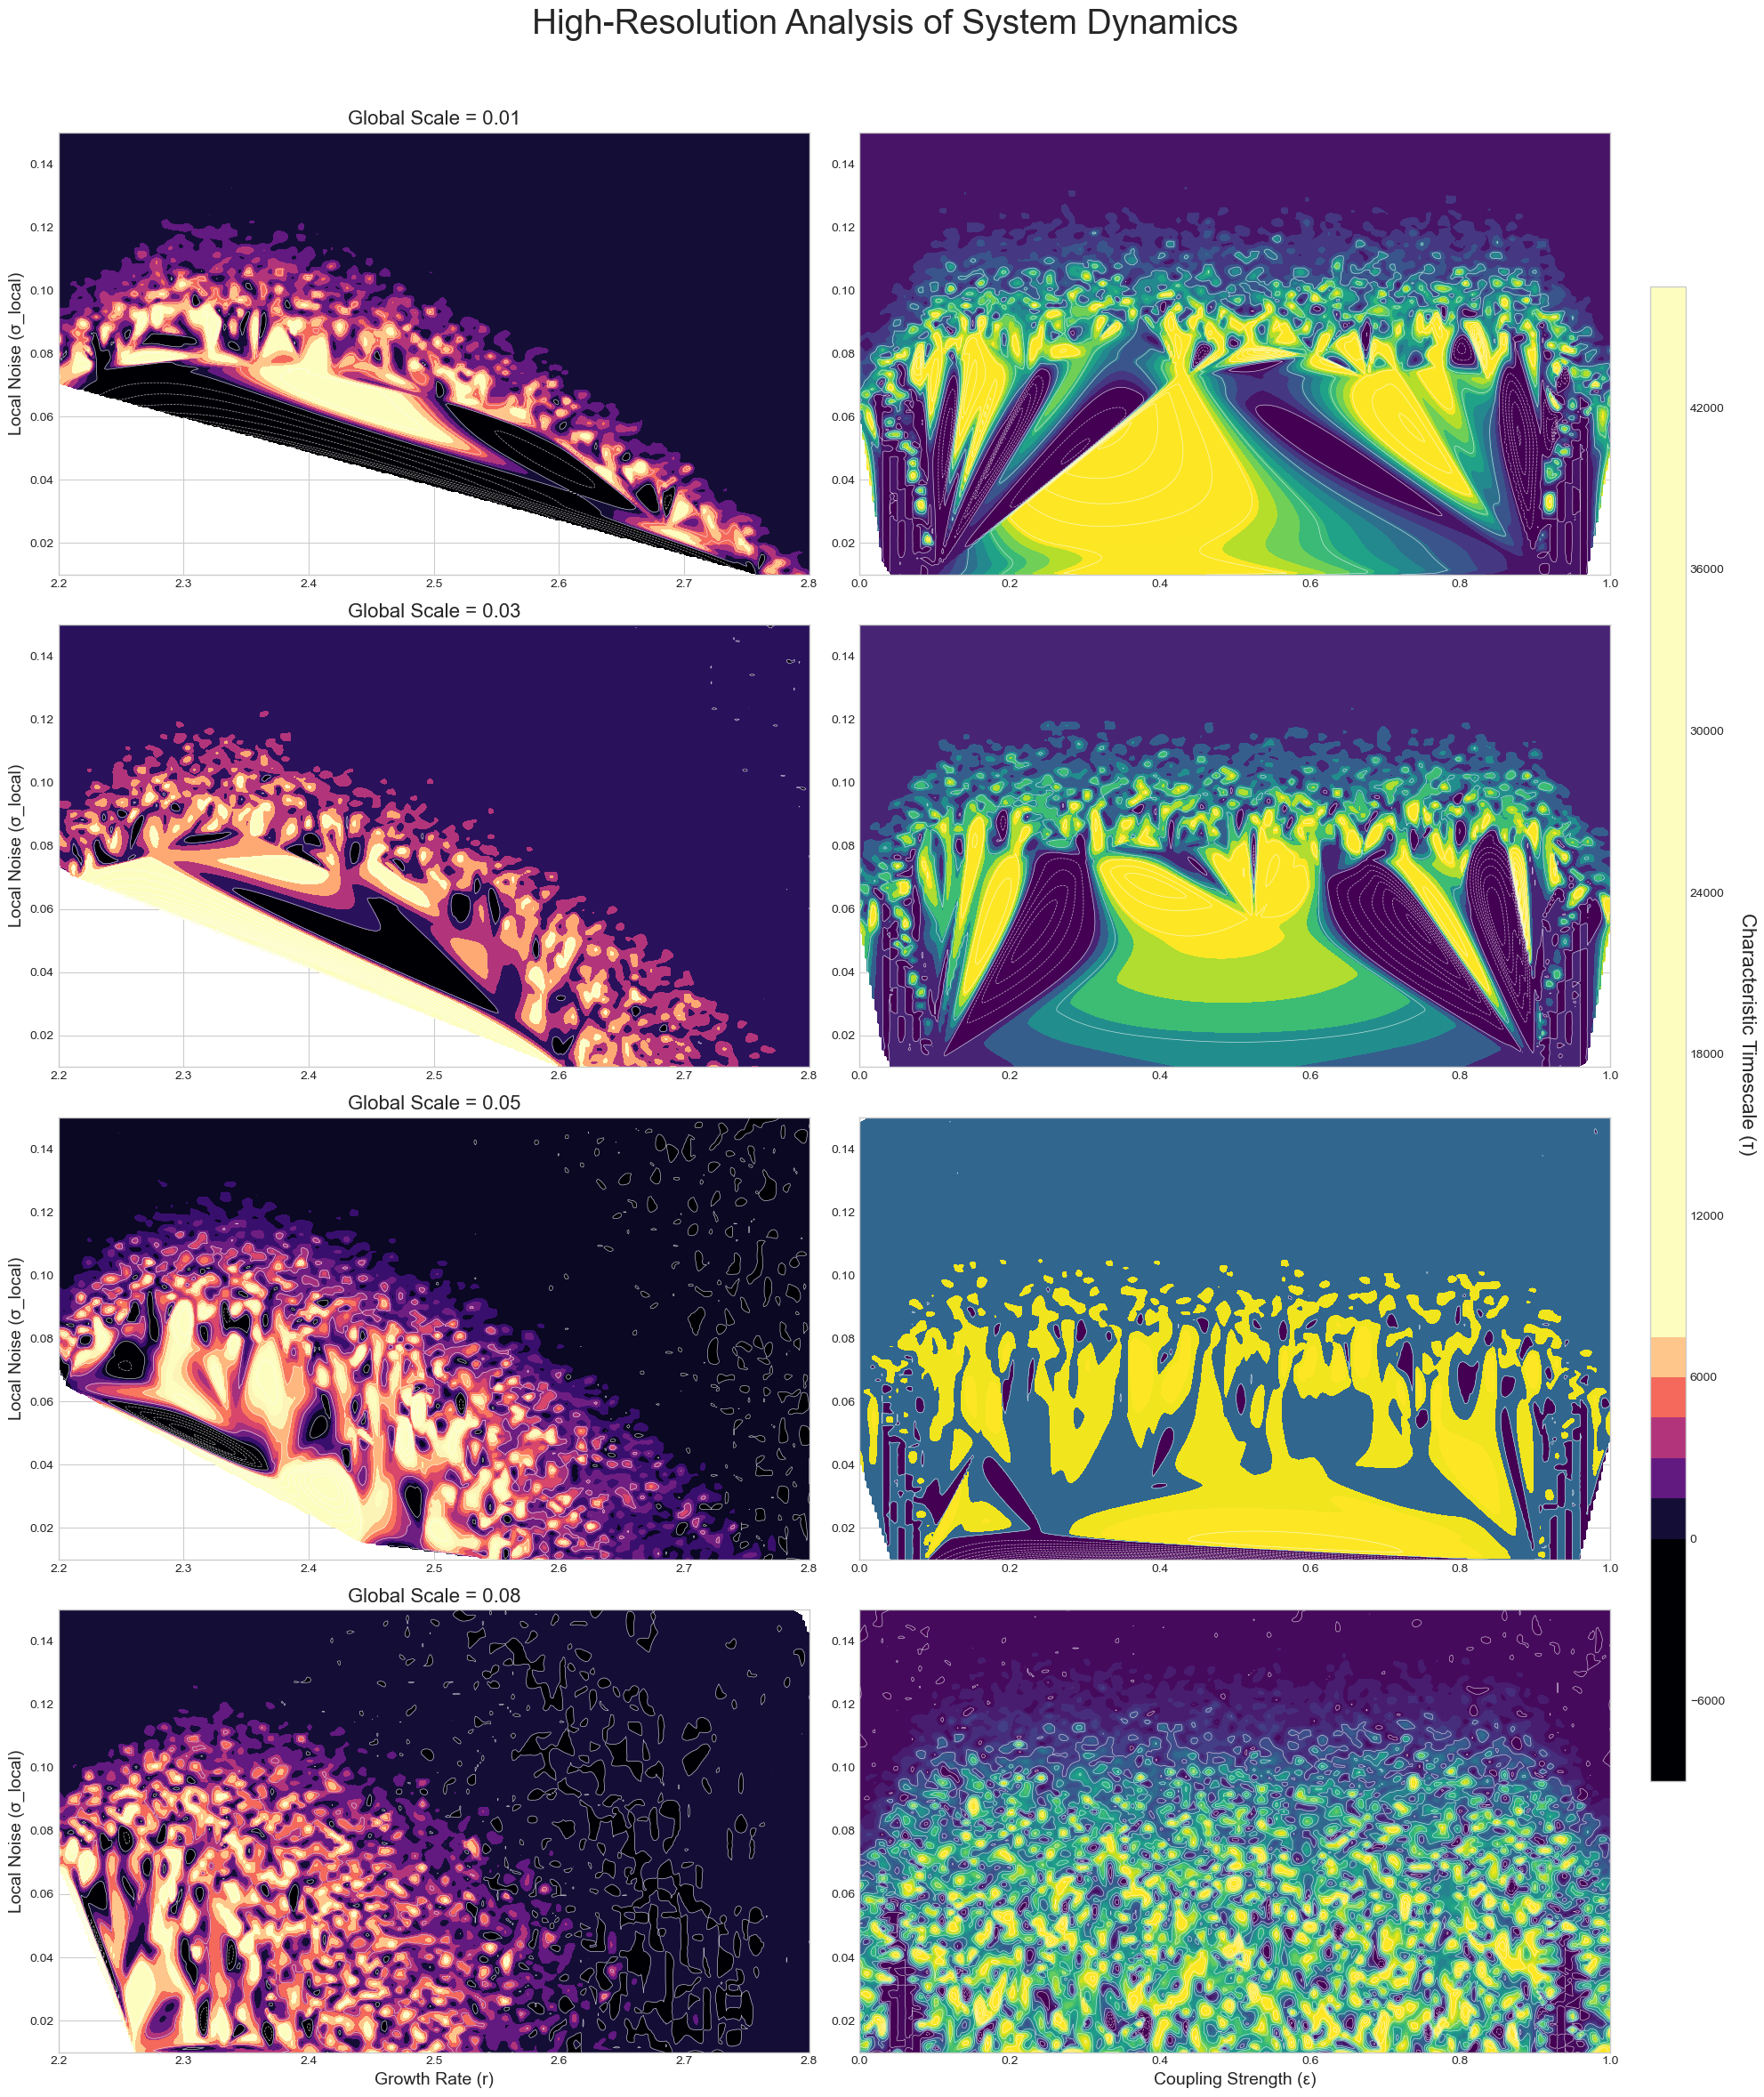

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
from joblib import Parallel, delayed
import pandas as pd
from scipy.interpolate import griddata

# --- Use a clean, professional plotting style ---
plt.style.use('seaborn-v0_8-whitegrid')

# --- The Final, Robust Worker Function ---
def get_tau_for_single_run(r, epsilon, local_sigma, global_scale, shock_prob):
    """
    A robust function to compute tau. It's designed to find tau when phase-switching
    (sign-flipping in M) occurs and return NaN otherwise.
    """
    # Updated simulation parameters
    num_steps = 40000
    transient = 100
    STABILITY_LIMIT = 1e9

    # --- Helper functions ---
    def R_ricker_internal(x, r_val):
        x_clipped = np.clip(x, -100, 100)
        return x_clipped * np.exp(r_val * (1 - x_clipped))
    def eta_internal(x, sigma):
        return x * np.exp(np.random.normal(0, sigma))
    def global_noise_internal(scale, prob):
        p_values = np.array([1.0 - prob, prob])
        σ = np.random.choice([0.1 * scale, 1 * scale], p=p_values)
        return np.random.normal(0, σ)
    def coupled_ricker_internal(x1, x2, r_val, eps_val, ls, gs, sp):
        g = global_noise_internal(gs, sp)
        x1_next = eta_internal((1 - eps_val) * R_ricker_internal(x1, r_val) + eps_val * R_ricker_internal(x2, r_val), ls) + g
        x2_next = eta_internal((1 - eps_val) * R_ricker_internal(x2, r_val) + eps_val * R_ricker_internal(x1, r_val), ls) + g
        return x1_next, x2_next

    # --- Simulation Loop ---
    X1, X2 = np.zeros(num_steps), np.zeros(num_steps)
    X1[0], X2[0] = 0.2, 1.3
    for t in range(num_steps - 1):
        X1[t + 1], X2[t + 1] = coupled_ricker_internal(X1[t], X2[t], r, epsilon, local_sigma, global_scale, shock_prob)
        if not (np.isfinite(X1[t + 1]) and np.isfinite(X2[t + 1])) or X1[t+1] > STABILITY_LIMIT:
            return np.nan

    # --- Analysis ---
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            X_bar = X1[transient:] + X2[transient:]
            if not np.all(np.isfinite(X_bar)) or len(X_bar) < 2: return np.nan
            M = (-1) ** (np.arange(len(X_bar) - 1) + 1) * np.diff(X_bar)
            if M.std() < 1e-6 or np.all(M > 0) or np.all(M < 0): return np.nan
            M_norm = M - np.nanmean(M)
            f = np.fft.fft(M_norm, n=2 * len(M_norm))
            acf_vals = np.fft.ifft(f * np.conj(f)).real[:len(M_norm)]
            if acf_vals[0] == 0: return np.nan
            acf_vals /= acf_vals[0]
            lags = np.arange(len(acf_vals))
            end_idx = np.argmax(acf_vals[1:] <= 0.0) + 1
            end_idx = end_idx if end_idx > 1 else len(acf_vals)
            x_fit, y_fit = lags[1:end_idx], acf_vals[1:end_idx]
            positive_points_mask = y_fit > 0
            if np.sum(positive_points_mask) < 2: return np.nan
            popt, _ = curve_fit(lambda k, t: np.exp(-k / t), x_fit[positive_points_mask], y_fit[positive_points_mask], p0=[10], maxfev=5000)
            return float(popt[0])
        except:
            return np.nan

# ==============================================================================
# --- PART 2: FULL HIGH-RESOLUTION ANALYSIS ---
# ==============================================================================

# --- High-Resolution Parameter Ranges ---
r_range_hires = np.linspace(2.2, 2.8, 100)
local_sigma_range_hires = np.linspace(0.01, 0.15, 80)
global_scale_slices_hires = np.array([0.01, 0.03, 0.05, 0.08])
epsilon_range_hires = np.linspace(0.0, 1.0, 100)

# --- Analysis 1: High-Res 3D Sweep (r, local_sigma, global_scale) ---
print("\n--- Starting FINAL Analysis 1: High-Res 3D Sweep of r vs. Noise ---")
param_pairs_3d_r = [(r, 0.5, ls, gs, 0.01) for gs in global_scale_slices_hires for ls in local_sigma_range_hires for r in r_range_hires]
print(f"Executing {len(param_pairs_3d_r)} simulations for Analysis 1...")
results_3d_r = Parallel(n_jobs=-1)(delayed(get_tau_for_single_run)(*p) for p in tqdm(param_pairs_3d_r))
df_3d_r = pd.DataFrame(param_pairs_3d_r, columns=['r', 'epsilon', 'local_sigma', 'global_scale', 'shock_prob'])
df_3d_r['tau'] = results_3d_r
df_3d_r.to_csv('results_FINAL_r_vs_noise.csv', index=False)
print("--- ✅ Analysis 1 Complete & Saved ---")

# --- Analysis 2: High-Res 3D Sweep (epsilon, local_sigma, global_scale) ---
print("\n--- Starting FINAL Analysis 2: High-Res 3D Sweep of epsilon vs. Noise ---")
param_pairs_3d_eps = [(2.4, eps, ls, gs, 0.01) for gs in global_scale_slices_hires for ls in local_sigma_range_hires for eps in epsilon_range_hires]
print(f"Executing {len(param_pairs_3d_eps)} simulations for Analysis 2. This will take a long time...")
results_3d_eps = Parallel(n_jobs=-1)(delayed(get_tau_for_single_run)(*p) for p in tqdm(param_pairs_3d_eps))
df_3d_eps = pd.DataFrame(param_pairs_3d_eps, columns=['r', 'epsilon', 'local_sigma', 'global_scale', 'shock_prob'])
df_3d_eps['tau'] = results_3d_eps
df_3d_eps.to_csv('results_FINAL_epsilon_vs_noise.csv', index=False)
print("--- ✅ Analysis 2 Complete & Saved ---")


# --- Plotting the High-Resolution Dashboard ---
print("\nSimulations complete. Generating final high-resolution dashboard...")
fig, axs = plt.subplots(len(global_scale_slices_hires), 2, figsize=(20, 24))
fig.suptitle('High-Resolution Analysis of System Dynamics', fontsize=28, y=0.98)

vmax = np.nanpercentile(np.concatenate([df_3d_r['tau'].dropna(), df_3d_eps['tau'].dropna()]), 98)

for i, gs in enumerate(global_scale_slices_hires):
    # Plotting for Analysis 1: Tau vs (r, local_sigma)
    ax1 = axs[i, 0]
    subset1 = df_3d_r[df_3d_r['global_scale'] == gs].dropna()
    if not subset1.empty:
        xi = np.linspace(subset1['r'].min(), subset1['r'].max(), 300)
        yi = np.linspace(subset1['local_sigma'].min(), subset1['local_sigma'].max(), 300)
        X, Y = np.meshgrid(xi, yi)
        Z = griddata((subset1['r'], subset1['local_sigma']), subset1['tau'], (X, Y), method='cubic')
        im1 = ax1.contourf(X, Y, Z, levels=50, cmap='magma', vmin=0, vmax=vmax)
        ax1.contour(X, Y, Z, levels=15, colors='white', linewidths=0.5, alpha=0.7)
    ax1.set_title(f'Global Scale = {gs}', fontsize=16)
    if i == len(global_scale_slices_hires) - 1:
        ax1.set_xlabel('Growth Rate (r)', fontsize=14)
    ax1.set_ylabel('Local Noise (σ_local)', fontsize=14)

    # Plotting for Analysis 2: Tau vs (epsilon, local_sigma)
    ax2 = axs[i, 1]
    subset2 = df_3d_eps[df_3d_eps['global_scale'] == gs].dropna()
    if not subset2.empty:
        xi_e = np.linspace(subset2['epsilon'].min(), subset2['epsilon'].max(), 300)
        yi_e = np.linspace(subset2['local_sigma'].min(), subset2['local_sigma'].max(), 300)
        X_e, Y_e = np.meshgrid(xi_e, yi_e)
        Z_e = griddata((subset2['epsilon'], subset2['local_sigma']), subset2['tau'], (X_e, Y_e), method='cubic')
        im2 = ax2.contourf(X_e, Y_e, Z_e, levels=50, cmap='viridis', vmin=0, vmax=vmax)
        ax2.contour(X_e, Y_e, Z_e, levels=15, colors='white', linewidths=0.5, alpha=0.7)
    if i == len(global_scale_slices_hires) - 1:
        ax2.set_xlabel('Coupling Strength (ε)', fontsize=14)

# Create a single, shared colorbar for all heatmaps
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Characteristic Timescale (τ)', fontsize=16, rotation=270, labelpad=25)

plt.tight_layout(rect=[0, 0, 0.92, 0.96])
plt.show()

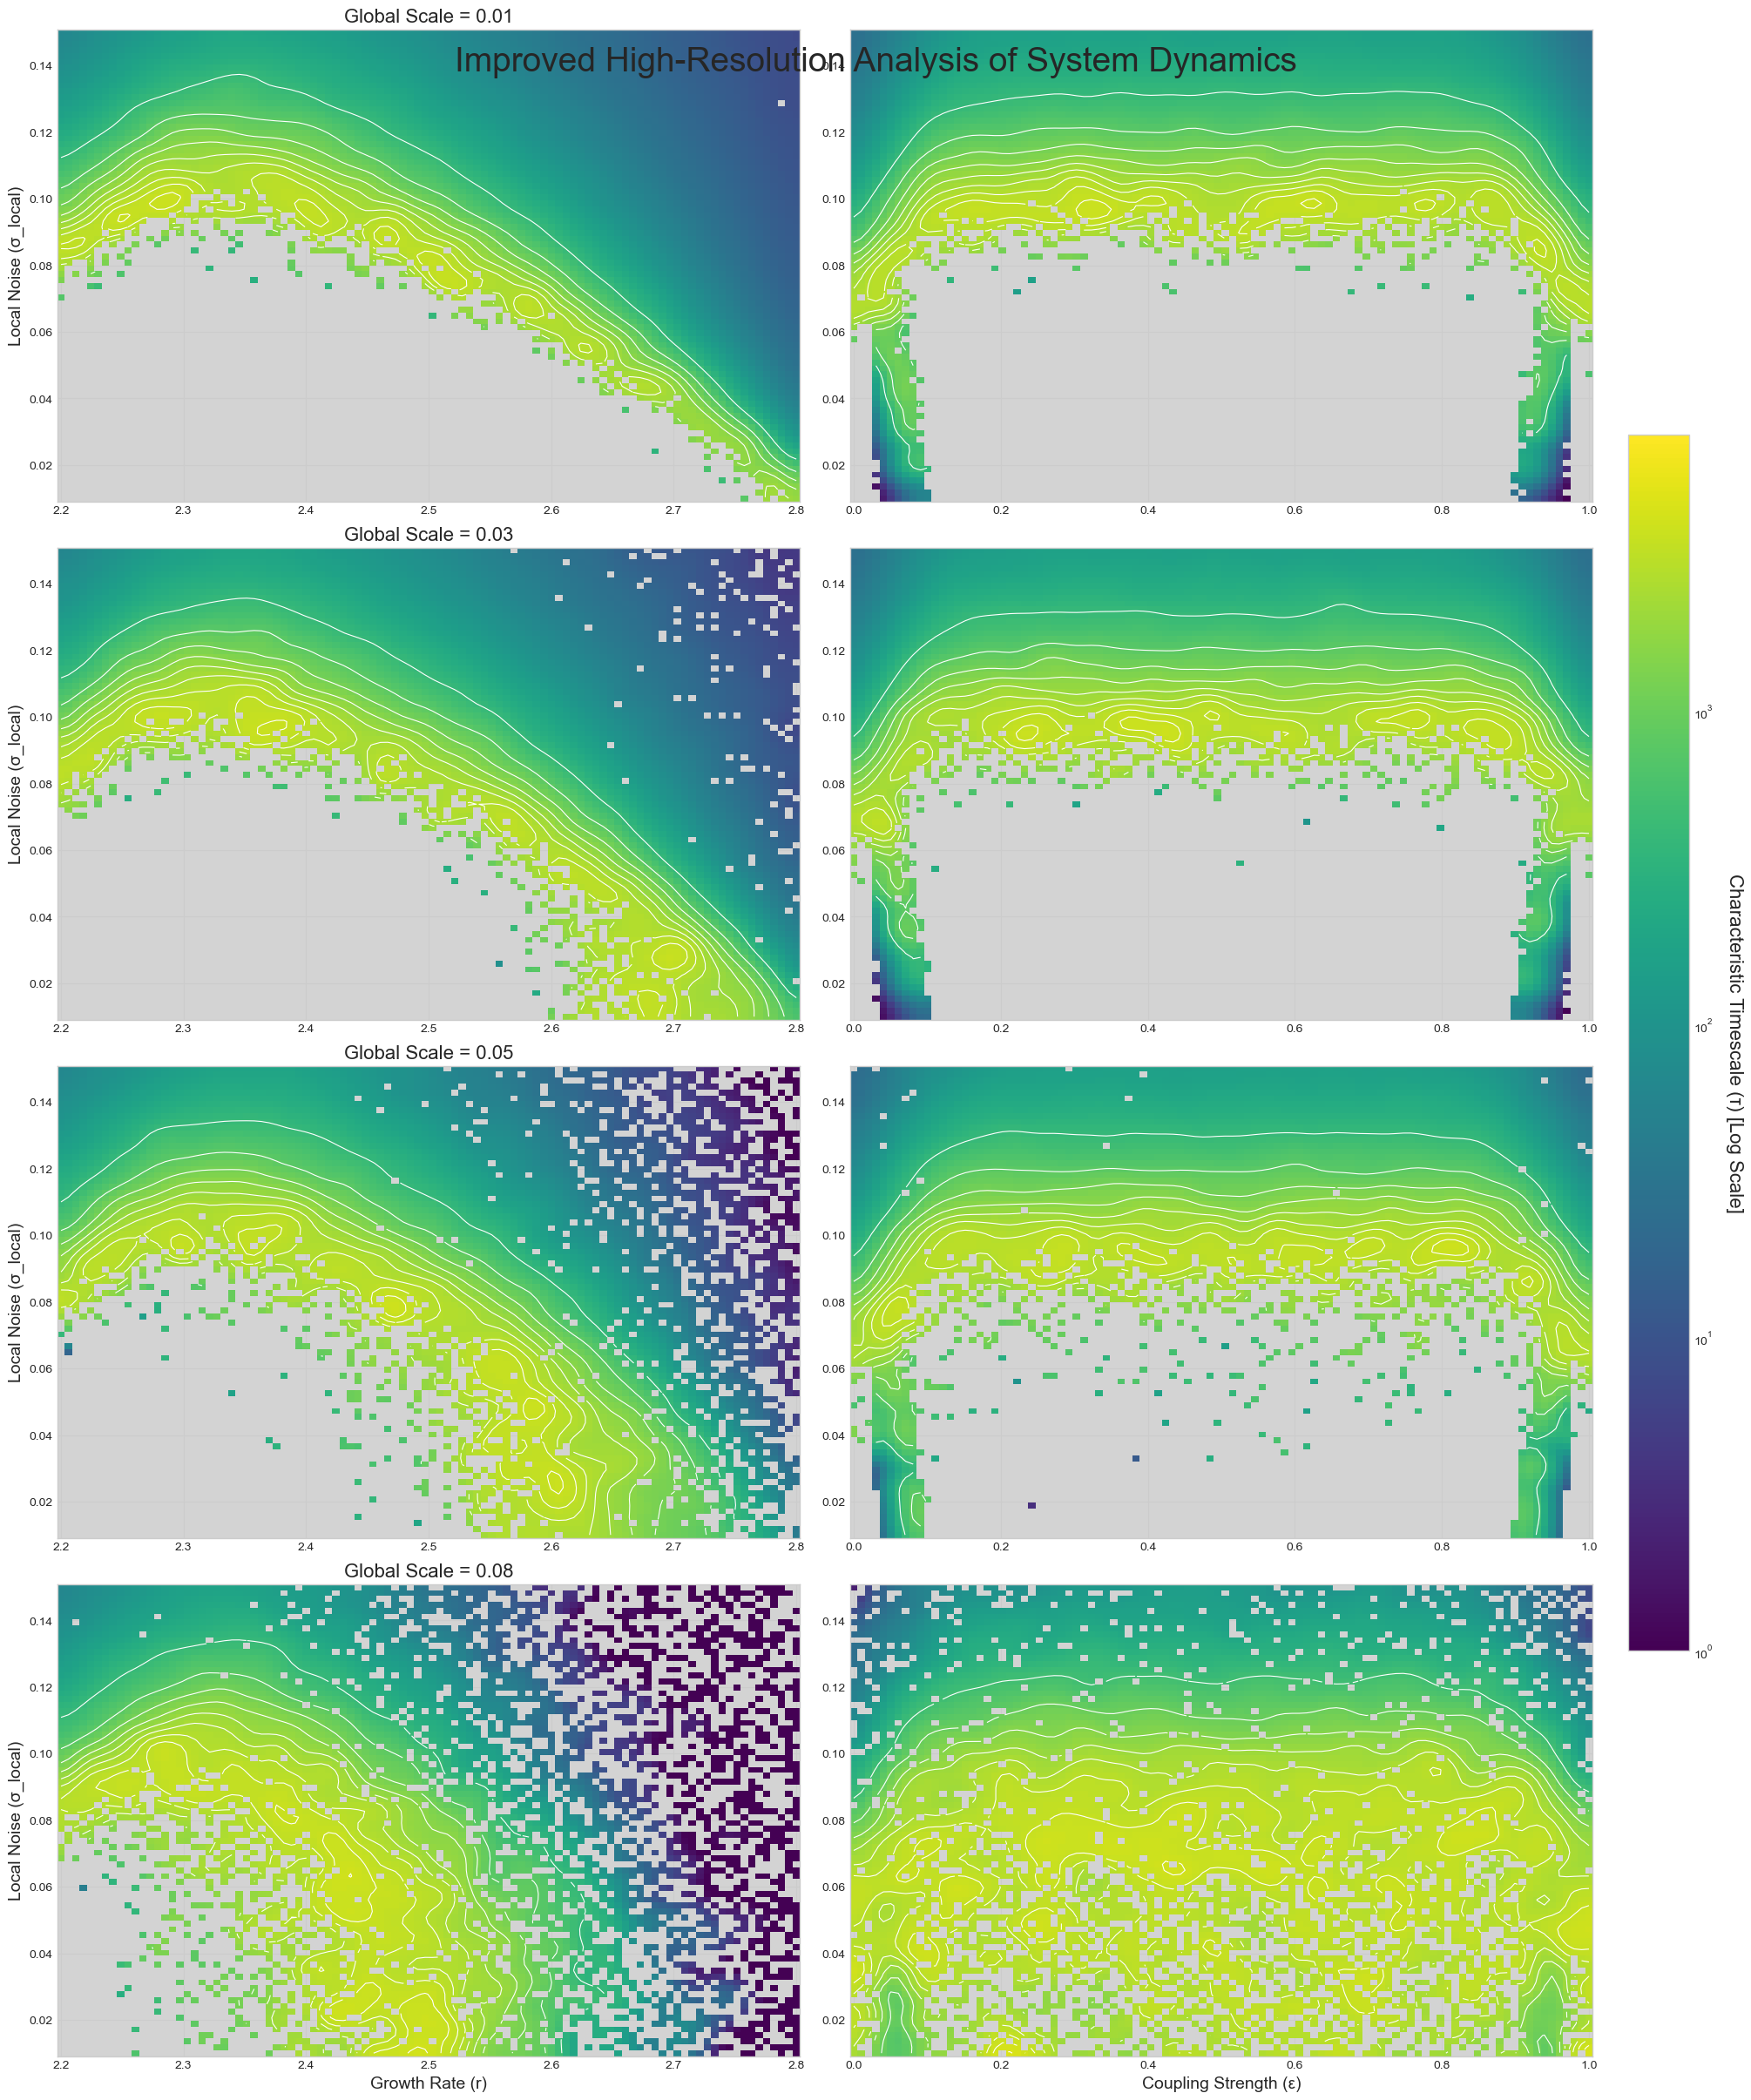

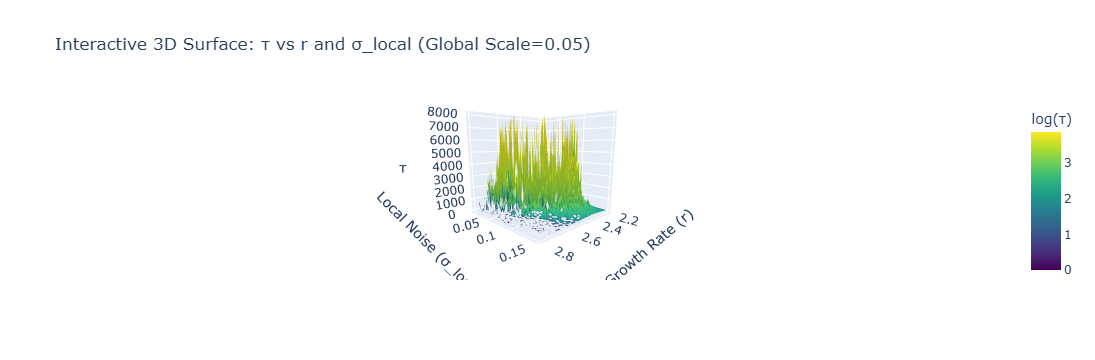

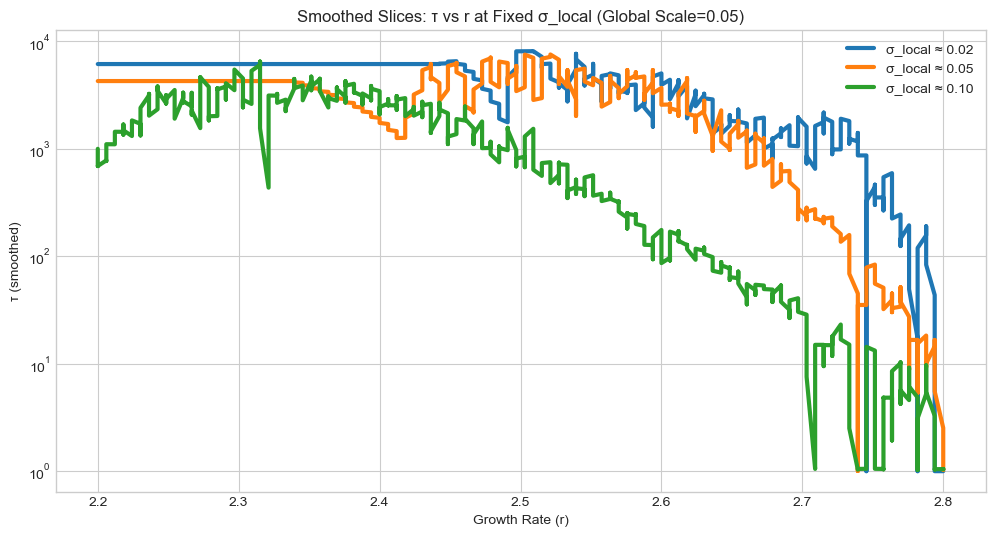

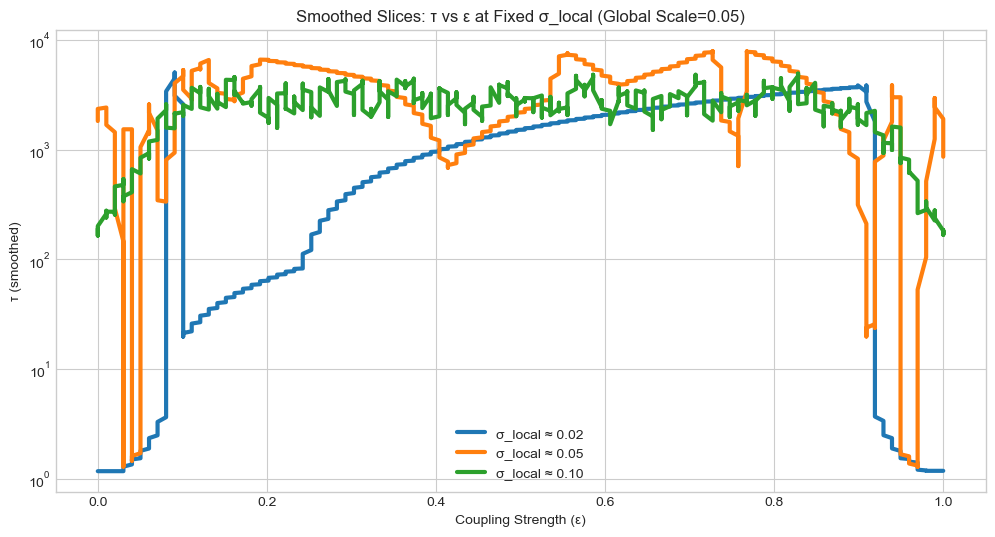

Correlation Analysis (Pearson corr between log(tau) and parameters)
For r dataset:
                log_tau             r   local_sigma  global_scale
log_tau       1.000000 -5.021280e-01 -2.570877e-01 -8.339458e-02
r            -0.502128  1.000000e+00 -3.163155e-15 -3.484045e-14
local_sigma  -0.257088 -3.163155e-15  1.000000e+00  4.129145e-15
global_scale -0.083395 -3.484045e-14  4.129145e-15  1.000000e+00
For epsilon dataset:
                log_tau       epsilon   local_sigma  global_scale
log_tau       1.000000  1.466038e-03 -1.477143e-01  1.178194e-01
epsilon       0.001466  1.000000e+00 -9.442578e-16 -3.314482e-15
local_sigma  -0.147714 -9.442578e-16  1.000000e+00  4.129145e-15
global_scale  0.117819 -3.314482e-15  4.129145e-15  1.000000e+00

Mean τ by Global Scale (from r dataset):
 global_scale
0.01     865.022736
0.03    1022.427406
0.05    1220.214740
0.08    1449.345222
Name: tau, dtype: float64

Mean τ by Local Sigma bins (from r dataset):
 local_sigma
(0.00986, 0.038]    228

C:\Users\rajya\AppData\Local\Temp\ipykernel_26528\3487215634.py:137: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\rajya\AppData\Local\Temp\ipykernel_26528\3487215634.py:141: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter  # For light denoising

# Load CSVs
df_r = pd.read_csv('results_FINAL_r_vs_noise.csv')
df_eps = pd.read_csv('results_FINAL_epsilon_vs_noise.csv')

# Filter invalid τ (negative or extreme; adjust thresholds based on model)
df_r['tau'] = df_r['tau'].clip(lower=1)  # τ >0, small positive for log
df_eps['tau'] = df_eps['tau'].clip(lower=1)
df_r.loc[df_r['tau'] > 1e6, 'tau'] = np.nan  # Cap outliers if needed
df_eps.loc[df_eps['tau'] > 1e6, 'tau'] = np.nan

# Extract unique sorted values
global_scale_slices = np.sort(np.unique(df_r['global_scale']))
local_sigma_range = np.sort(np.unique(df_r['local_sigma']))

# Use a clean, professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# Static Dashboard: Consistent cmap, log norm, smoothing (increased sigma for smoother plots)
fig, axs = plt.subplots(len(global_scale_slices), 2, figsize=(20, 24), constrained_layout=True)
fig.suptitle('Improved High-Resolution Analysis of System Dynamics', fontsize=28, y=0.98)
vmin, vmax = 1, np.nanpercentile(np.concatenate([df_r['tau'].dropna(), df_eps['tau'].dropna()]), 98)

for i, gs in enumerate(global_scale_slices):
    # Left: vs r
    subset1 = df_r[df_r['global_scale'] == gs]
    if not subset1.empty:
        pivot1 = subset1.pivot(index='local_sigma', columns='r', values='tau').sort_index().sort_index(axis=1)
        grid1 = pivot1.values
        grid1_smoothed = gaussian_filter(np.nan_to_num(grid1), sigma=2)  # Increased sigma for smoother appearance
        grid1_smoothed[np.isnan(grid1)] = np.nan  # Restore NaNs
        r_range = pivot1.columns
        local_sigma_range = pivot1.index
        ax1 = axs[i, 0]
        ax1.set_facecolor('lightgray')
        im1 = ax1.pcolormesh(r_range, local_sigma_range, grid1_smoothed, shading='auto', cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
        ax1.contour(r_range, local_sigma_range, grid1_smoothed, levels=10, colors='white', linewidths=0.8)
    ax1.set_title(f'Global Scale = {gs:.2f}', fontsize=16)
    ax1.set_xlabel('Growth Rate (r)' if i == len(global_scale_slices)-1 else '', fontsize=14)
    ax1.set_ylabel('Local Noise (σ_local)', fontsize=14)

    # Right: vs epsilon
    subset2 = df_eps[df_eps['global_scale'] == gs]
    if not subset2.empty:
        pivot2 = subset2.pivot(index='local_sigma', columns='epsilon', values='tau').sort_index().sort_index(axis=1)
        grid2 = pivot2.values
        grid2_smoothed = gaussian_filter(np.nan_to_num(grid2), sigma=2)  # Increased sigma for smoother appearance
        grid2_smoothed[np.isnan(grid2)] = np.nan
        epsilon_range = pivot2.columns
        ax2 = axs[i, 1]
        ax2.set_facecolor('lightgray')
        im2 = ax2.pcolormesh(epsilon_range, local_sigma_range, grid2_smoothed, shading='auto', cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
        ax2.contour(epsilon_range, local_sigma_range, grid2_smoothed, levels=10, colors='white', linewidths=0.8)
    ax2.set_xlabel('Coupling Strength (ε)' if i == len(global_scale_slices)-1 else '', fontsize=14)

# Add colorbar attached to axes to avoid tight_layout incompatibility
cbar = fig.colorbar(im1, ax=axs, orientation='vertical', shrink=0.6, pad=0.02)
cbar.set_label('Characteristic Timescale (τ) [Log Scale]', fontsize=16, rotation=270, labelpad=25)

plt.savefig('improved_dashboard.png')  # Save for reference
plt.show()

# Interactive 3D Example (for one slice, e.g., global_scale=0.05; vs r and sigma_local)
subset_3d = df_r[df_r['global_scale'] == 0.05]
if not subset_3d.empty:
    pivot_3d = subset_3d.pivot(index='local_sigma', columns='r', values='tau').sort_index().sort_index(axis=1)
    Z = pivot_3d.values
    r_range = pivot_3d.columns
    local_sigma_range = pivot_3d.index
    X, Y = np.meshgrid(r_range, local_sigma_range)
    log_Z = np.log10(np.maximum(Z, vmin))
    fig_3d = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, surfacecolor=log_Z, colorscale='Viridis', colorbar_title='log(τ)', cmin=np.log10(vmin), cmax=np.log10(vmax))])
    fig_3d.update_layout(title='Interactive 3D Surface: τ vs r and σ_local (Global Scale=0.05)',
                         scene=dict(xaxis_title='Growth Rate (r)', yaxis_title='Local Noise (σ_local)', zaxis_title='τ'))
    fig_3d.show()

# Bonus: Smoothed Line Slices using rolling mean (τ vs r at fixed σ_local levels)
fixed_sigmas = [0.02, 0.05, 0.1]  # Example levels
plt.figure(figsize=(12, 6))
for sig in fixed_sigmas:
    subset_line = df_r[(df_r['global_scale'] == 0.05) & (np.isclose(df_r['local_sigma'], sig, atol=0.005))].sort_values('r')
    if not subset_line.empty:
        # Interpolate and fill NaNs
        subset_line['tau'] = subset_line['tau'].interpolate(method='linear', limit_direction='both').bfill().ffill()
        # Smooth with rolling mean
        smoothed_tau = subset_line['tau'].rolling(window=5, center=True, min_periods=2).mean()
        plt.plot(subset_line['r'], smoothed_tau, label=f'σ_local ≈ {sig:.2f}', lw=3)
plt.xlabel('Growth Rate (r)')
plt.ylabel('τ (smoothed)')
plt.title('Smoothed Slices: τ vs r at Fixed σ_local (Global Scale=0.05)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Additional: Smoothed Line Slices using rolling mean for ε (τ vs ε at fixed σ_local levels)
plt.figure(figsize=(12, 6))
for sig in fixed_sigmas:
    subset_line = df_eps[(df_eps['global_scale'] == 0.05) & (np.isclose(df_eps['local_sigma'], sig, atol=0.005))].sort_values('epsilon')
    if not subset_line.empty:
        # Interpolate and fill NaNs
        subset_line['tau'] = subset_line['tau'].interpolate(method='linear', limit_direction='both').bfill().ffill()
        # Smooth with rolling mean
        smoothed_tau = subset_line['tau'].rolling(window=5, center=True, min_periods=2).mean()
        plt.plot(subset_line['epsilon'], smoothed_tau, label=f'σ_local ≈ {sig:.2f}', lw=3)
plt.xlabel('Coupling Strength (ε)')
plt.ylabel('τ (smoothed)')
plt.title('Smoothed Slices: τ vs ε at Fixed σ_local (Global Scale=0.05)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# To study relationships: Example correlation analysis
print("Correlation Analysis (Pearson corr between log(tau) and parameters)")

# For df_r
df_r['log_tau'] = np.log10(np.maximum(df_r['tau'], 1))
corr_r = df_r[['log_tau', 'r', 'local_sigma', 'global_scale']].corr()
print("For r dataset:\n", corr_r)

# For df_eps
df_eps['log_tau'] = np.log10(np.maximum(df_eps['tau'], 1))
corr_eps = df_eps[['log_tau', 'epsilon', 'local_sigma', 'global_scale']].corr()
print("For epsilon dataset:\n", corr_eps)

# Grouped means to see trends
mean_tau_by_global = df_r.groupby('global_scale')['tau'].mean()
print("\nMean τ by Global Scale (from r dataset):\n", mean_tau_by_global)

mean_tau_by_local = df_r.groupby(pd.cut(df_r['local_sigma'], bins=5))['tau'].mean()
print("\nMean τ by Local Sigma bins (from r dataset):\n", mean_tau_by_local)

# Additional grouped means for global vs local noise impact
mean_tau_by_global_local = df_r.groupby(['global_scale', pd.cut(df_r['local_sigma'], bins=5)])['tau'].mean().unstack()
print("\nMean τ by Global Scale and Local Sigma bins (from r dataset):\n", mean_tau_by_global_local)

C:\Users\rajya\AppData\Local\Temp\ipykernel_26528\1669021362.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



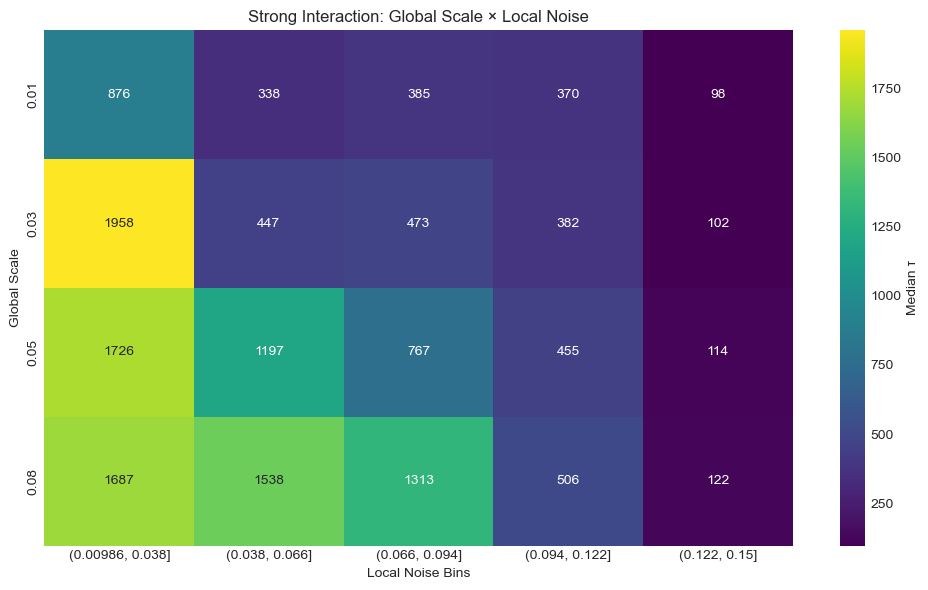

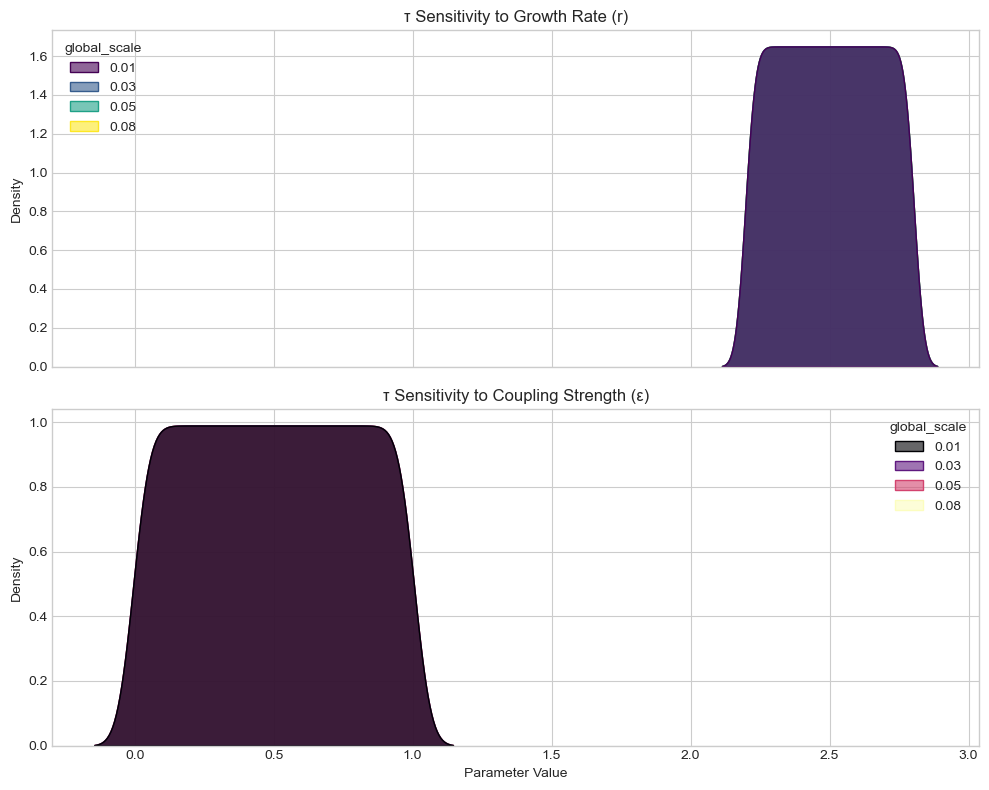

C:\Users\rajya\AppData\Local\Temp\ipykernel_26528\1669021362.py:60: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.

C:\Users\rajya\AppData\Local\Temp\ipykernel_26528\1669021362.py:60: UserWarning:

Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.

C:\Users\rajya\AppData\Local\Temp\ipykernel_26528\1669021362.py:61: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.

C:\Users\rajya\AppData\Local\Temp\ipykernel_26528\1669021362.py:61: UserWarning:

Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.

C:\Users\rajya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.

C:\Users\rajya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.



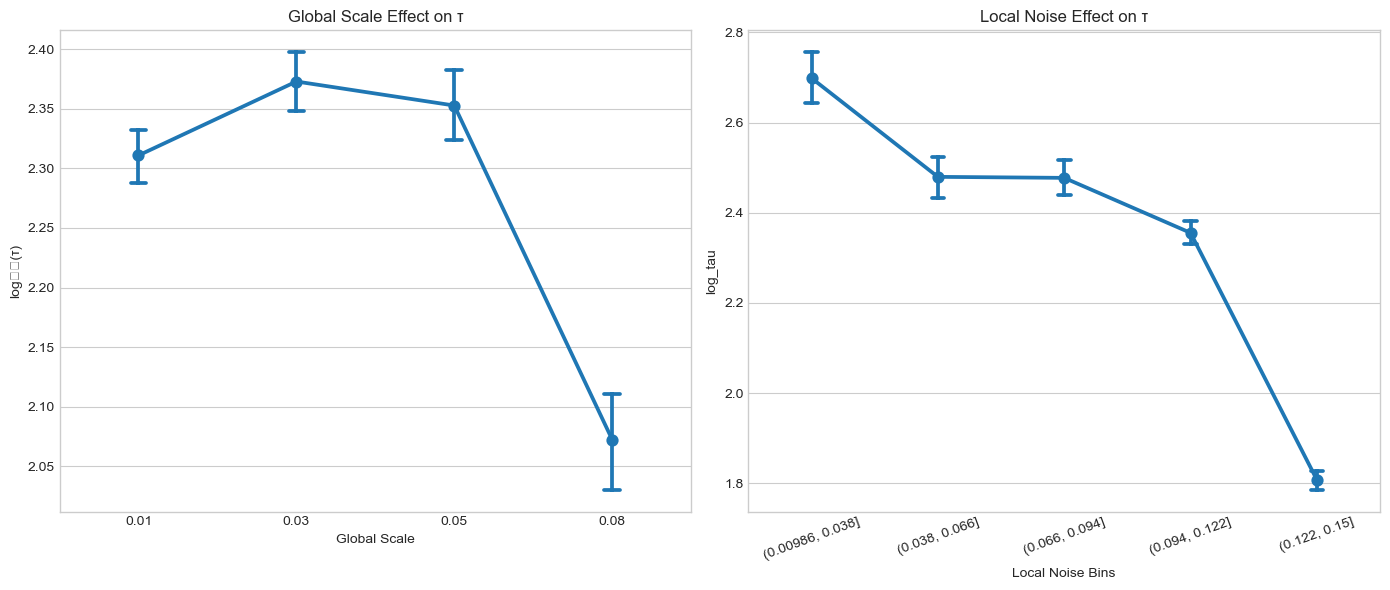

TypeError: Input z must be 2D, not 1D

C:\Users\rajya\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.

C:\Users\rajya\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.



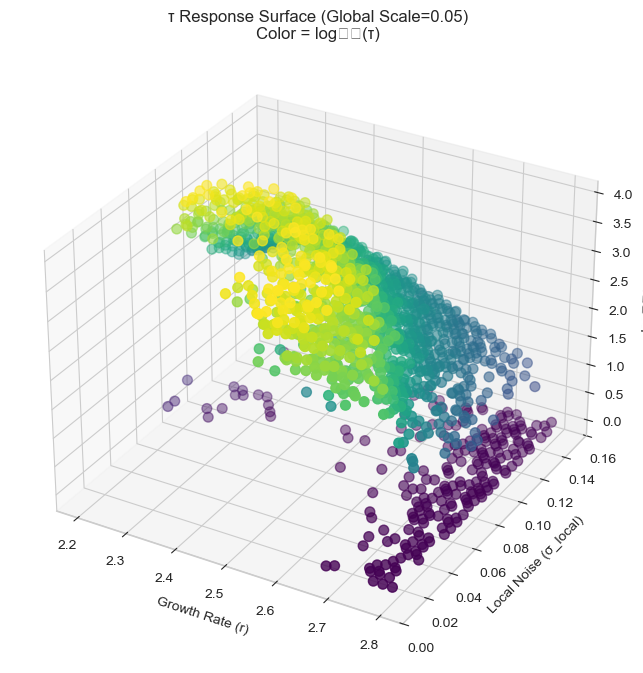

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.ndimage import gaussian_filter

# Data Preparation (add this before plotting)
df_r['log_tau'] = np.log10(df_r['tau'])
df_eps['log_tau'] = np.log10(df_eps['tau'])

# 1. Interaction Heatmap (Global Scale vs Local Noise)
plt.figure(figsize=(10, 6))
heatmap_data = df_r.groupby(['global_scale', pd.cut(df_r['local_sigma'], bins=5)])['tau'].median().unstack()
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="viridis", 
            cbar_kws={'label': 'Median τ'})
plt.title("Strong Interaction: Global Scale × Local Noise")
plt.xlabel("Local Noise Bins")
plt.ylabel("Global Scale")
plt.tight_layout()
plt.savefig('global_local_interaction.png', dpi=300)
plt.show()

# 2. Parameter Sensitivity Ridgeline Plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Growth rate sensitivity
sns.kdeplot(data=df_r, x='r', hue='global_scale', 
            fill=True, alpha=0.6, ax=ax[0], 
            palette="viridis", common_norm=False)
ax[0].set_title("τ Sensitivity to Growth Rate (r)")
ax[0].set_ylabel("Density")

# Coupling strength sensitivity
sns.kdeplot(data=df_eps, x='epsilon', hue='global_scale', 
            fill=True, alpha=0.6, ax=ax[1],
            palette="magma", common_norm=False)
ax[1].set_title("τ Sensitivity to Coupling Strength (ε)")
ax[1].set_xlabel("Parameter Value")
plt.tight_layout()
plt.savefig('parameter_sensitivity.png', dpi=300)
plt.show()

# 3. Binned Analysis with Error Bars
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Global scale effect
sns.pointplot(data=df_r, x='global_scale', y='log_tau', 
              errorbar=('ci', 95), capsize=0.1, ax=ax[0])
ax[0].set_title("Global Scale Effect on τ")
ax[0].set_xlabel("Global Scale")
ax[0].set_ylabel("log₁₀(τ)")

# Local noise effect
df_r['local_bin'] = pd.cut(df_r['local_sigma'], bins=5)
sns.pointplot(data=df_r, x='local_bin', y='log_tau',
              errorbar=('ci', 95), capsize=0.1, ax=ax[1])
ax[1].set_title("Local Noise Effect on τ")
ax[1].set_xlabel("Local Noise Bins")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig('binned_effects.png', dpi=300)
plt.show()

# 4. Enhanced 3D Surface (with interaction highlighting)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Sample every 3rd point for clarity
plot_data = df_r[df_r['global_scale'] == 0.05].iloc[::3]

sc = ax.scatter(plot_data['r'], plot_data['local_sigma'], plot_data['log_tau'],
               c=plot_data['log_tau'], cmap='viridis', s=50)

ax.set_xlabel("Growth Rate (r)")
ax.set_ylabel("Local Noise (σ_local)")
ax.set_zlabel("log₁₀(τ)")
ax.set_title("τ Response Surface (Global Scale=0.05)\nColor = log₁₀(τ)")

# Add contour projections
ax.contour(plot_data['r'], plot_data['local_sigma'], plot_data['log_tau'], 
           zdir='z', offset=ax.get_zlim()[0], cmap='coolwarm')
plt.colorbar(sc, label='log₁₀(τ)')
plt.tight_layout()
plt.savefig('3d_surface.png', dpi=300)
plt.show()